# **Project – Drone inspection images of wind turbine**
<br>
University of Porto - School of Engineering <br>
Master’s degree in Data Science & Engineering (MECD) – FEUP<br>
<br>
Computer Vision - CV<br>
October 2023 <br>
<br>
Authors: Paulo Portela (up202200871) and Luís Henriques (up202204386)
<br>

# **Project Context**
Drone images offer a unique aerial perspective of wind turbines, allowing for a comprehensive 
view of the entire structure, including the blades, nacelle, and tower. This perspective is crucial 
for inspecting and evaluating the overall condition of the turbine. Routine drone inspections are 
an integral part of wind turbine  maintenance. These images  help maintenance teams identify 
issues  like  blade  erosion,  lightning  strikes,  or  structural  damage  that  may  require  immediate 
attention.

# **Introduction**

Efficient inspection of wind turbines is crucial to ensure the reliability and continuous functionality of these vital renewable energy generators. With the advancement of technology, the use of drone-captured images has emerged as a valuable tool for inspecting wind turbines, providing a comprehensive perspective of the entire structure, including blades, nacelle, and tower. The project at hand, named "Project 7 – Drone inspection images of wind turbine," aims to develop an Artificial Intelligence (AI) model dedicated to defect detection in wind turbines through the analysis of these images.

**Objectives of the Work**:

1. **Development of the AI Model for Defect Detection**: The primary goal of this project is to **develop and optimize an AI model** to **identify defects in wind turbines more accurately and efficiently** from images captured by drones. This optimization aims to improve the model's ability to **recognize and categorize** defects such as blade erosion, lightning strikes, or structural damage, providing a more robust tool for maintenance teams;

2. **Exploration of Data Augmentation Techniques**: A fundamental approach to improving the model's effectiveness is the application of **data augmentation techniques**. These techniques aim to **diversify and expand the training dataset**, enhancing the model's ability to generalize to different conditions and inspection scenarios. Throughout the project, specific data augmentation techniques tailored to wind turbine images will be explored and implemented;

3. **Comparison with Existing Models**: The work will include a comprehensive comparison of the results obtained by the developed model with at least two widely recognized existing models in defect detection in images, such as members of the YOLO family, Faster R-CNN, DETR, among others. This comparison will assess the relative effectiveness of the proposed model compared to established approaches;

4. **Evaluation Using Appropriate Metrics**: In the evaluation phase, distinct metrics tailored to the specific nature of the problem will be employed for the two primary approaches undertaken in this project: classification and regression:

   - **For Classification (Anomaly Detection)**: Metrics such as **accuracy, precision, recall, and F1-score** will be utilized to assess the effectiveness of the model in accurately classifying images and determining the **presence or absence of anomalies in wind turbine components**. This evaluation is pivotal in gauging the model's proficiency in distinguishing normal conditions from potential defects like blade erosion, lightning strikes, or structural damage;

   - **For Regression (Coordinate Identification)**: Given the regression-based approach for identifying the **center point coordinates and bounding box of anomalies**, metrics specific to regression tasks will be incorporated. These may include **Mean Squared Error (MSE), Mean Absolute Error (MAE), or other relevant regression metrics**. The focus here is on evaluating the precision of the model in predicting the spatial location and extent of identified anomalies;

   - **Object Detection (and Mean Average Precision (MAP))**: **Object detection tasks combine elements of both classification and regression**. The model not only **classifies objects** but also **localizes them by predicting bounding box coordinates**. MAP is often used to evaluate the precision of object detection models. It considers both the accuracy of object classification and the correctness of the predicted bounding boxes.

5. **Discussion in Light of Related Research**: The results' analysis will be contextualized in relation to the state of the art, considering relevant research, such as the article provided at https://www.sciencedirect.com/science/article/pii/S2352484721005102, and other pertinent sources, such as the study on "Slice-Aided Defect Detection in Ultra High-Resolution Wind Turbine Blade Images" available at hhttps://www.mdpi.com/2075-1702/11/10/953/htm.

This project aims not only to enhance the defect detection capability in wind turbines but also to contribute to advancing knowledge in the application of artificial intelligence for predictive maintenance in critical renewable energy infrastructure.


**Note Regarding Project Directory Structure**:

For seamless integration and execution of the project, it is essential to maintain a specific directory structure. Please ensure the presence of a folder named "data" in the project directory. Within the **"data" folder**, two sub-folders are required:

- **Annotations Folder**: This folder, named **"Annotations"** should include **three JSON files**: "test.json," "train.json," and "validation.json." These files contain the necessary annotations for the testing, training, and validation datasets, respectively;

- **Images Folder**: This folder must include **all images** relevant to the project, encompassing data from the years **2017 and 2018**.


Ensuring the accurate organization of the project directory with the specified structure is vital for the proper functioning of the codebase, data access, and overall project workflow. Please verify and adhere to this directory structure before initiating the project to guarantee optimal performance and seamless execution.

## **1. Imports**

In [1]:
# Importing necessary libraries
import os
import cv2 as cv
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader

#Ignore user warnings
import warnings
warnings.filterwarnings("ignore")

## **2. Checking Annotations**

### **2.1 Loading Data**

**Purpose**: Loading training, validation, and test data from JSON files;

**Key Aspects**:
- The data is stored in separate JSON files for each split (train, validation and test);
- File paths are provided as strings.

In [2]:
# Load training, validation and test data from JSON files
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/val.json') as f:
    valJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

### **2.2 Data exploration**

**Purpose**: Explore information about classes, training images and annotations;

**Key Aspects**:
- Information about classes, training images and annotations is extracted from the JSON files;
- Classes are displayed with their IDs, names and supercategories;
- Images and annotations are displayed in a structured format.

In [143]:
# Explore information about classes, training images and annotations
classes = trainJSON['categories']
train_images = trainJSON['images']
val_images = valJSON['images']
test_images = testJSON['images']
train_annotations = trainJSON['annotations']
val_annotations = valJSON['annotations']
test_annotations = testJSON['annotations']


# Exibição das informações sobre classes, imagens de treinamento e algumas anotações
# Supondo que classes, train_images e train_annotations sejam listas de dicionários
print('========= Classes =========')
classes_table = [[cls['id'], cls['name']] for cls in classes]
print(tabulate(classes_table, headers=['ID', 'Name'], tablefmt='fancy_grid', stralign='center'))
print()

print('========= Train Images =========')
train_images_table = [[img['id'], img['file_name'], img['width'], img['height'], img['depth']] for img in train_images[:5]]
print(tabulate(train_images_table, headers=['ID', 'File Name', 'Width', 'Height', 'Depth'], tablefmt='fancy_grid', stralign='center'))
print()

print('========= Train Annotations =========')
train_annotations_table = [[ann['image_id'], ann['id'], ann['bbox'], ann['area'], ann['category_id']] for ann in train_annotations[:5]]
print(tabulate(train_annotations_table, headers=['Image ID', 'Annotation ID', 'BBox', 'Area', 'Category ID'], tablefmt='fancy_grid', stralign='center'))

========= Classes =========
╒══════╤════════╕
│   ID │  Name  │
╞══════╪════════╡
│    1 │ LE;ER  │
├──────┼────────┤
│    4 │ SF;PO  │
├──────┼────────┤
│    0 │ VG;MT  │
├──────┼────────┤
│    2 │ LR;DA  │
├──────┼────────┤
│    3 │ LE;CR  │
╘══════╧════════╛

========= Train Images =========
╒══════╤══════════════════╤═════════╤══════════╤═════════╕
│   ID │    File Name     │   Width │   Height │   Depth │
╞══════╪══════════════════╪═════════╪══════════╪═════════╡
│    0 │ DJI_0058_1_3.JPG │    1024 │     1024 │       3 │
├──────┼──────────────────┼─────────┼──────────┼─────────┤
│    1 │ DJI_0013_0_3.JPG │    1024 │     1024 │       3 │
├──────┼──────────────────┼─────────┼──────────┼─────────┤
│    2 │ DJI_0013_1_1.JPG │    1024 │     1024 │       3 │
├──────┼──────────────────┼─────────┼──────────┼─────────┤
│    3 │ DJI_0168_0_3.JPG │    1024 │     1024 │       3 │
├──────┼──────────────────┼─────────┼──────────┼─────────┤
│    4 │ DJI_0168_0_4.JPG │    1024 │     1024 │       

### **2.3 Image Name Preprocessing**

**Purpose**: Pre-process image names for consistency;

**Key Aspects**:
- Extracts relevant portions from image file names to standardize them;
- Removes duplicates from the lists of image names;
- Display pre-processed image names.

In [145]:
# Pre-processing of image names
train_images_names = []
val_images_names = []
test_images_names = []

for metadata in train_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    train_images_names.append(img_name)

for metadata in val_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    val_images_names.append(img_name)

for metadata in test_images:
    img_name = metadata['file_name'][:8] + metadata['file_name'][-4:]
    test_images_names.append(img_name)


# Drop duplicates from the lists
train_images_names = list(set(train_images_names))
val_images_names = list(set(val_images_names))
test_images_names = list(set(test_images_names))


# Display image name pre-processing results
print('========= Train images names =========')
train_images_table = [[name] for name in train_images_names[:11]]
print(tabulate(train_images_table, headers=['Train Image Names'], tablefmt='fancy_grid', stralign='center'))
print()

print('========= Validation images names =========')
val_images_table = [[name] for name in val_images_names[:11]]
print(tabulate(val_images_table, headers=['Validation Image Names'], tablefmt='fancy_grid', stralign='center'))
print()

print('========= Test images names =========')
test_images_table = [[name] for name in test_images_names[:11]]
print(tabulate(test_images_table, headers=['Test Image Names'], tablefmt='fancy_grid', stralign='center'))

========= Train images names =========
╒═════════════════════╕
│  Train Image Names  │
╞═════════════════════╡
│    DJI_0104.JPG     │
├─────────────────────┤
│    DJI_0336.JPG     │
├─────────────────────┤
│    DJI_0753.JPG     │
├─────────────────────┤
│    DJI_0014.JPG     │
├─────────────────────┤
│    DJI_0995.JPG     │
├─────────────────────┤
│    DJI_0423.JPG     │
├─────────────────────┤
│    DJI_0195.JPG     │
├─────────────────────┤
│    DJI_0250.JPG     │
├─────────────────────┤
│    DJI_0451.JPG     │
├─────────────────────┤
│    DJI_0004.JPG     │
├─────────────────────┤
│    DJI_0758.JPG     │
╘═════════════════════╛

========= Validation images names =========
╒══════════════════════════╕
│  Validation Image Names  │
╞══════════════════════════╡
│       DJI_0119.JPG       │
├──────────────────────────┤
│       DJI_0048.JPG       │
├──────────────────────────┤
│       DJI_0124.JPG       │
├──────────────────────────┤
│       DJI_0238.JPG       │
├─────────────────────────

## **3. Data Preparation**

### **3.1 Data Set Definition (NordtankDataset) and Image Preprocessing**

**Purpose**: Define a custom dataset for PyTorch and perform basic preprocessing on images.

**Key Aspects**:
- The **NordtankDataset** class is a subclass of torch.utils.data.Dataset that initializes with image names and optional transformations;
- __getitem__ loads an image, converts its color space, and transforms it into a PyTorch tensor.

In [5]:
class NordtankDataset(torch.utils.data.Dataset):
    def __init__(self, images_names, transform=None):
        # Initialization of dataset with image names and optional transforms
        self.images_names = images_names
        self.transform = transform

    def __len__(self):
        # Return the size of the dataset (number of images)
        return len(self.images_names)

    def __getitem__(self, idx):
        # Returns a specific image with its corresponding index
        img_name = self.images_names[idx]
        img_path = img_name
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = torch.from_numpy(image.transpose(2, 0, 1))

        if self.transform:
            image = self.transform(image)

        image = image.permute(1, 2, 0)

        return image

### **3.2 Dividing Images into Sub-Images (DivideImage)**

**Purpose**: Divide large images into smaller sub-images.

**Key Aspects**:
- The DivideImage function divides the image into sub-images of a specific size and resizes (with a value of 256 x 256) them.

In [6]:
def DivideImage(image, sub_size, resize):
    # Splits an image into sub-images and resizes each one
    sub_images = []
    sub_images_resized = []
    h, w, c = image.shape
    image_np = image.numpy()  # Convert PyTorch tensor to NumPy array

    for i in range(0, h, sub_size):
        for j in range(0, w, sub_size):
            sub_image = image_np[i:i + sub_size, j:j + sub_size]
            sub_images.append(sub_image)
            # Resize the sub-image to 100x100
            sub_image_resized = cv.resize(sub_image, (resize, resize))
            sub_images_resized.append(torch.tensor(sub_image_resized))

    # Get the indices of the sub-images that have a size of 1024x1024
    idx = [i for i, sub_image in enumerate(sub_images) if sub_image.shape == (sub_size, sub_size, c)]

    # Filter sub_images_resized by indexes
    sub_images_resized = [sub_images_resized[i] for i in idx]

    return sub_images_resized

### **3.3 Split Image Visualization (PlotDividedImage)**

**Purpose**: Visualize the division of the image into sub-images.

**Key Aspects**:
- The PlotDividedImage function creates a plot showing the original image with red squares indicating the sub-images.

In [39]:
def PlotDividedImage(image, size, resize):
    """
    Plot a test image with red squares showing the sub-images.

    Parameters:
    - image: NumPy array representing the original image.
    - size: Size of each sub-image.
    - resize: Resize factor for visualization.
    """
    H, W, C = image.shape
    sub_images = DivideImage(image, size, resize)
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(0, H, size):
        for j in range(0, W, size):
            rect = matplotlib.patches.Rectangle((j, i), size, size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()

### **3.4 Bounding Box Visualization (PlotBoundingBox)**

**Purpose**: Visualize bounding boxes on images.

**Key Aspects**:
- The PlotBoundingBox function adds a red bounding box to the image.

In [40]:
def PlotBoundingBox(image, bbox):
    """
    Plot the annotation bounding box on an image.

    Parameters:
    - image: NumPy array representing the original image.
    - bbox: Tuple (x, y, width, height) representing the bounding box coordinates.
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    x, y, w, h = bbox
    rect = matplotlib.patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

### **3.5 Center Point Visualization (PlotCenterPoint)**

**Purpose**: Visualize central points on images.

**Key Aspects**:
- The PlotCenterPoint function adds a red central point to the image.

In [42]:
def PlotCenterPoint(image, bbox):
    """
    Plot the center point of the bounding box on an image.

    Parameters:
    - image: NumPy array representing the original image.
    - bbox: Tuple (center_x, center_y) representing the center point coordinates.
    """
    fig, ax = plt.subplots()
    ax.imshow(image)
    center_x, center_y = bbox
    ax.scatter(center_x, center_y, c='r', s=10)
    plt.show()

### **3.6 Creating the Dataset with Sub-Images (CreateDatasetSubImages)**

**Purpose**: Create a dataset with sub-images, labels, central points and bounding boxes.

**Key Aspects**:
- Iterates over original images, divides them into sub-images, and creates lists of labels, central points and bounding boxes.

In [10]:
def CreateDatasetSubImages(dataset, dataframe, train_image_path_lst, sub_size, resize):
    # Initialize lists to store sub-images, labels, center points, and bounding boxes
    sub_images = []
    sub_labels = []
    centerpoints = []
    bboxes = []

    # Iterate over unique image names in the dataframe
    for image_name in dataframe['file_name'].unique():
        # Select rows from the dataframe corresponding to the current image
        sub_images_df = dataframe[dataframe['file_name'] == image_name]
        sub_image_labels = [5] * 10
        cpoints_sub_image = [(0, 0)] * 10
        bboxes_sub_image = [(0, 0, 0, 0)] * 10

        # Get the index of the current image in the dataset
        idx = train_image_path_lst.index('data/Images/' + image_name)
        image = dataset[idx]

        # Iterate over rows in the sub-images dataframe
        for index, sub_image in sub_images_df.iterrows():
            row = int(sub_image['sub_image_row'])
            col = int(sub_image['sub_image_col'])
            sub_image_labels[(row * 5) + col] = int(sub_image['category_id'])
            center_x = sub_image['bbox'][0] + sub_image['bbox'][2] / 2
            center_y = sub_image['bbox'][1] + sub_image['bbox'][3] / 2
            cpoints_sub_image[(row * 5) + col] = (center_x, center_y)
            bboxes_sub_image[(row * 5) + col] = sub_image['bbox']

        # Divide the original image into sub-images and append to the lists
        sub_images += DivideImage(image, sub_size, resize)
        sub_labels += sub_image_labels
        centerpoints += cpoints_sub_image
        bboxes += bboxes_sub_image

    # Calculate the resizing factor
    factor = resize / sub_size

    # Multiply the bounding box values by the factor if the value is not None
    centerpoints = [tuple(factor * x for x in bbox) if bbox is not None else None for bbox in centerpoints]
    bboxes = [tuple(factor * x for x in bbox) if bbox is not None else None for bbox in bboxes]

    return sub_images, sub_labels, centerpoints, bboxes

### **3.7 Integration of Images and Annotations (IntegrateImagesAnnotations)**

**Purpose**: Integrate information from images and annotations into a DataFrame.

**Key Aspects**:
- Uses Pandas to integrate information from images and annotations, eliminating duplicates based on sub-image coordinates.

In [11]:
def IntegrateImagesAnnotations(images, annotations):

    images_df = pd.DataFrame(images)
    annotations_df = pd.DataFrame(annotations)

    images_df.drop(columns = ['folder', 'path', 'width', 'height', 'depth'], inplace = True)
    annotations_df.drop(columns = ['segmented', 'area', 'segmentation', 'iscrowd', 'pose', 'truncated', 'difficult'], inplace = True)

    # Create two new columns in train_images_df that contain the row and column of the sub-image with the annotation
    images_df['sub_image_row'] = images_df['file_name'].str[9:10].astype(int)
    images_df['sub_image_col'] = images_df['file_name'].str[11:12].astype(int)
    images_df['file_name'] = images_df['file_name'].str[:8] + images_df['file_name'].str[-4:]

    #Change the name of the column "id" to "image_id" in the train_images_df
    images_df.rename(columns = {'id': 'image_id'}, inplace = True)

    # Merge train_images_df and train_annotations_df using the key "image_id"
    df = pd.merge(images_df, annotations_df, on = 'image_id').drop(columns = ['id'])

    # Delete all rows that have duplicate values in the columns "image_id", "sub_image_row", and "sub_image_col"
    df.drop_duplicates(subset = ['image_id', 'sub_image_row', 'sub_image_col'], keep = False, inplace = True)

    return df

### **3.8 Preparation of Original Datasets**

**Purpose**: Prepare original datasets for training, validation, and testing.

**Key Aspects**:
- Combines images and annotations to create DataFrames for training, validation and testing;
- Initializes datasets for original images and creates datasets for sub-images, labels, central points and bounding boxes.

In [12]:
# Combine images and annotations to create dataframes for training, validation, and testing
train_df = IntegrateImagesAnnotations(train_images, train_annotations)
val_df = IntegrateImagesAnnotations(val_images, val_annotations)
test_df = IntegrateImagesAnnotations(test_images, test_annotations)

# Get all image paths in the 'data/Images' directory
images = glob.glob('data/Images/*.JPG')

# Initialize lists to store paths for training, validation, and testing
train_images_paths = []
val_images_paths = []
test_images_paths = []

# Iterate over all images and categorize them into their respective sets
for img in images:
    img_name = os.path.basename(img)

    if img_name in train_images_names:
        train_images_paths.append(img.replace("\\", "/"))
    elif img_name in val_images_names:
        val_images_paths.append(img.replace("\\", "/"))
    elif img_name in test_images_names:
        test_images_paths.append(img.replace("\\", "/"))

# Print the corrected paths
print("Train Images Paths:", train_images_paths)
print("Validation Images Paths:", val_images_paths)
print("Test Images Paths:", test_images_paths)

# Create datasets for the original images
TrainOriginalDataset = NordtankDataset(train_images_paths)
ValOriginalDataset = NordtankDataset(val_images_paths)
TestOriginalDataset = NordtankDataset(test_images_paths)

# Create sub-images, labels, centerpoints, and bounding boxes datasets for training, validation, and testing
train_sub_images, train_sub_labels, train_centerpoints, train_bboxes = CreateDatasetSubImages(TrainOriginalDataset, train_df, train_images_paths, 1024, 256)
val_sub_images, val_sub_labels, val_centerpoints, val_bboxes = CreateDatasetSubImages(ValOriginalDataset, val_df, val_images_paths, 1024, 256)
test_sub_images, test_sub_labels, test_centerpoints, test_bboxes = CreateDatasetSubImages(TestOriginalDataset, test_df, test_images_paths, 1024, 256)

# Normalize pixel values to the range [0, 1] for all images
train_sub_images = [image / 255 for image in train_sub_images]
val_sub_images = [image / 255 for image in val_sub_images]
test_sub_images = [image / 255 for image in test_sub_images]

Train Images Paths: ['data/Images/DJI_0004.JPG', 'data/Images/DJI_0005.JPG', 'data/Images/DJI_0007.JPG', 'data/Images/DJI_0008.JPG', 'data/Images/DJI_0009.JPG', 'data/Images/DJI_0010.JPG', 'data/Images/DJI_0011.JPG', 'data/Images/DJI_0012.JPG', 'data/Images/DJI_0013.JPG', 'data/Images/DJI_0014.JPG', 'data/Images/DJI_0016.JPG', 'data/Images/DJI_0017.JPG', 'data/Images/DJI_0018.JPG', 'data/Images/DJI_0019.JPG', 'data/Images/DJI_0020.JPG', 'data/Images/DJI_0022.JPG', 'data/Images/DJI_0023.JPG', 'data/Images/DJI_0024.JPG', 'data/Images/DJI_0025.JPG', 'data/Images/DJI_0027.JPG', 'data/Images/DJI_0028.JPG', 'data/Images/DJI_0030.JPG', 'data/Images/DJI_0031.JPG', 'data/Images/DJI_0032.JPG', 'data/Images/DJI_0034.JPG', 'data/Images/DJI_0035.JPG', 'data/Images/DJI_0037.JPG', 'data/Images/DJI_0044.JPG', 'data/Images/DJI_0046.JPG', 'data/Images/DJI_0049.JPG', 'data/Images/DJI_0050.JPG', 'data/Images/DJI_0051.JPG', 'data/Images/DJI_0052.JPG', 'data/Images/DJI_0056.JPG', 'data/Images/DJI_0057.JPG',

### **3.9 Visualizations (Divided Image, Boundix Boxe in the Image and the Central Point in the Image)**

**PlotDividedImage(TrainOriginalDataset[0], 1024, 128)**:

- **Purpose**: Visualize the division of the first image in the training set into sub-images.

- **Key Aspects**:
  - Uses the PlotDividedImage function to display the original image with red squares indicating the sub-images;
  - Sub-images are generated from the TrainOriginalDataset with a sub-image size of 1024 and a resize factor of 128.

**PlotBoundingBox(train_sub_images[1013], train_bboxes[1013])**:

- **Purpose**: Visualize bounding boxes in a specific sub-image from the training set.

- **Key Aspects**:
  - Uses the PlotBoundingBox function to add a red bounding box to the specified sub-image;
  - The sub-image and its corresponding bounding box are selected from the training data.

**PlotCenterPoint(train_sub_images[1013], train_centerpoints[1013])**:

- **Purpose**: Visualize the central point in a specific sub-image from the training set.

- **Key Aspects**:
  - Uses the PlotCenterPoint function to add a red central point to the specified sub-image;
  - The sub-image and its corresponding central point are selected from the training data.

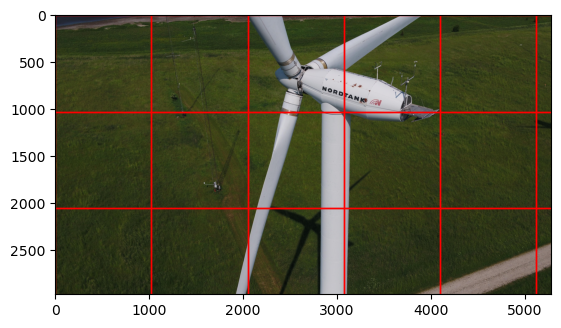

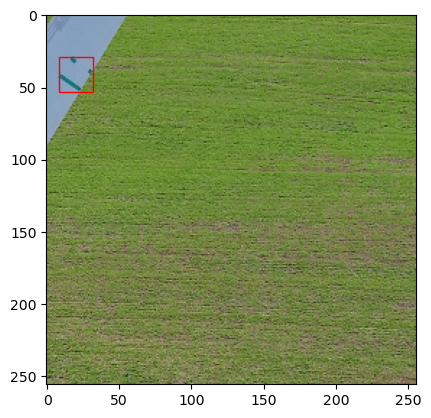

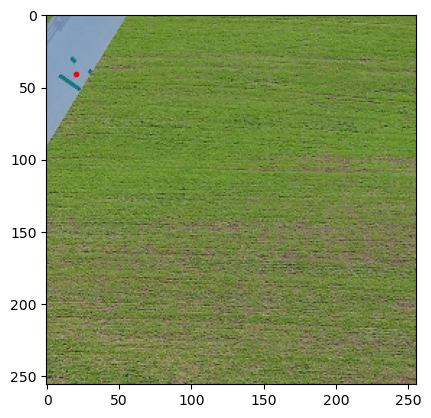

In [43]:
PlotDividedImage(TrainOriginalDataset[0], 1024, 128)
PlotBoundingBox(train_sub_images[1013], train_bboxes[1013])
PlotCenterPoint(train_sub_images[1013], train_centerpoints[1013])

### **3.10 Data Handling by Category**

**Function to retrieve annotations based on a target label**:

- **Purpose**: Extract annotations and categorize them based on labels.

- **Key Aspects**:
  - The GetAnnotationsByLabel function retrieves sub-images, center points, and bounding boxes for a specified label.

**Function to duplicate category data to reach a target size**:

- **Purpose**: Duplicate data for certain categories to achieve a target size.
- **Key Aspects**:
  - The DuplicateCategoryData function creates copies of original data and duplicates them to reach a specified target size.


**Extract annotations and categorize them based on labels for training, validation, and test data**:
- **Key Aspects**:
  - Annotations are categorized for labels  0, 1, 2, 3, 4 and 5in the training, validation, and test sets.
  - Data for label 5 (neg1) represents the absence of a label.

**Dictionary to store duplicated and original data per category**:
- **Key Aspects**:
  - Duplicated and original data are organized in dictionaries for each category, including images, center points, bounding boxes, and labels.

**Print class counts for original, duplicated, validation, and test data**:
- **Key Aspects**:
  - Class counts are printed for each category, indicating the number of elements in the dataset.
  - Totals for each dataset type (original, duplicated, validation, and test) are also provided.

In [14]:
# Function to retrieve annotations based on a target label
def GetAnnotationsByLabel(sub_images, labels, centerpoints, bboxes, target_label):
    # Initialize lists to store data for the target label
    sub_images_category = []
    centerpoints_category = []
    bboxes_category = []

    # Iterate through the annotations
    for i in range(len(labels)):
        # Check if the current annotation has the target label
        if labels[i] == target_label:
            # Append data for the target label
            sub_images_category.append(sub_images[i])
            centerpoints_category.append(centerpoints[i])
            bboxes_category.append(bboxes[i])

    # Return the data for the target label
    return sub_images_category, centerpoints_category, bboxes_category


# Function to duplicate category data to reach a target size
def DuplicateCategoryData(images, centerpoints, bboxes, target_size):
    # Get the initial size of the data
    initial_size = len(images)
    current_size = len(images)

    # Create copies of the original data
    images_copy = images.copy()
    centerpoints_copy = centerpoints.copy()
    bboxes_copy = bboxes.copy()

    # Duplicate data until the target size is reached
    while current_size < target_size - initial_size:
        # Select a random index from the original data
        random_index = random.randint(0, initial_size - 1)

        # Retrieve the data at the random index
        duplicated_image = images[random_index]

        # Append the duplicated data to the copies
        images_copy.append(duplicated_image)
        centerpoints_copy.append(centerpoints[random_index])
        bboxes_copy.append(bboxes[random_index])

        # Update the current size
        current_size += 1

    # Return the duplicated data
    return images_copy, centerpoints_copy, bboxes_copy

In [15]:
# Extract annotations and categorize them based on labels for training data
train_sub_images_neg1, train_centerpoints_neg1, train_bboxes_neg1 = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 5)
train_sub_images_zero, train_centerpoints_zero, train_bboxes_zero = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 0)
train_sub_images_one, train_centerpoints_one, train_bboxes_one = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 1)
train_sub_images_two, train_centerpoints_two, train_bboxes_two = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 2)
train_sub_images_three, train_centerpoints_three, train_bboxes_three = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 3)
train_sub_images_four, train_centerpoints_four, train_bboxes_four = GetAnnotationsByLabel(train_sub_images, train_sub_labels, train_centerpoints, train_bboxes, 4)


# Extract annotations and categorize them based on labels for validation data
val_sub_images_neg1, val_centerpoints_neg1, val_bboxes_neg1 = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 5)
val_sub_images_zero, val_centerpoints_zero, val_bboxes_zero = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 0)
val_sub_images_one, val_centerpoints_one, val_bboxes_one = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 1)
val_sub_images_two, val_centerpoints_two, val_bboxes_two = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 2)
val_sub_images_three, val_centerpoints_three, val_bboxes_three = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 3)
val_sub_images_four, val_centerpoints_four, val_bboxes_four = GetAnnotationsByLabel(val_sub_images, val_sub_labels, val_centerpoints, val_bboxes, 4)


# Extract annotations and categorize them based on labels for test data
test_sub_images_neg1, test_centerpoints_neg1, test_bboxes_neg1 = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 5)
test_sub_images_zero, test_centerpoints_zero, test_bboxes_zero = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 0)
test_sub_images_one, test_centerpoints_one, test_bboxes_one = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 1)
test_sub_images_two, test_centerpoints_two, test_bboxes_two = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 2)
test_sub_images_three, test_centerpoints_three, test_bboxes_three = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 3)
test_sub_images_four, test_centerpoints_four, test_bboxes_four = GetAnnotationsByLabel(test_sub_images, test_sub_labels, test_centerpoints, test_bboxes, 4)


# Duplicate data for certain categories to achieve a target size
sub_images_zero_dup, centerpoints_zero_dup, bboxes_zero_dup = DuplicateCategoryData(
    train_sub_images_zero, train_centerpoints_zero, train_bboxes_zero, 1529
)
sub_images_one_dup, centerpoints_one_dup, bboxes_one_dup = DuplicateCategoryData(
    train_sub_images_one, train_centerpoints_one, train_bboxes_one, 1529
)
sub_images_two_dup, centerpoints_two_dup, bboxes_two_dup = DuplicateCategoryData(
    train_sub_images_two, train_centerpoints_two, train_bboxes_two, 1529
)
sub_images_three_dup, centerpoints_three_dup, bboxes_three_dup = DuplicateCategoryData(
    train_sub_images_three, train_centerpoints_three, train_bboxes_three, 1529
)
sub_images_four_dup, centerpoints_four_dup, bboxes_four_dup = DuplicateCategoryData(
    train_sub_images_four, train_centerpoints_four, train_bboxes_four, 1529
)


# Dictionary to store duplicated data per category
dup_data_per_category = {
    'zero': {'images': sub_images_zero_dup, 'centerpoints': centerpoints_zero_dup, 'bboxes': bboxes_zero_dup, 'labels':0},
    'one': {'images': sub_images_one_dup, 'centerpoints': centerpoints_one_dup, 'bboxes': bboxes_one_dup, 'labels':1 },
    'two': {'images': sub_images_two_dup, 'centerpoints': centerpoints_two_dup, 'bboxes': bboxes_two_dup, 'labels':2},
    'three': {'images': sub_images_three_dup, 'centerpoints': centerpoints_three_dup, 'bboxes': bboxes_three_dup, 'labels':3},
    'four': {'images': sub_images_four_dup, 'centerpoints': centerpoints_four_dup, 'bboxes': bboxes_four_dup, 'labels':4},
}

# Dictionary to store original data per category for training
train_data_per_category = {
    'neg1': {'images': train_sub_images_neg1, 'centerpoints': train_centerpoints_neg1, 'bboxes': train_bboxes_neg1, 'labels':5},
    'zero': {'images': train_sub_images_zero, 'centerpoints': train_centerpoints_zero, 'bboxes': train_bboxes_zero, 'labels':0},
    'one': {'images': train_sub_images_one, 'centerpoints': train_centerpoints_one, 'bboxes': train_bboxes_one, 'labels':1},
    'two': {'images': train_sub_images_two, 'centerpoints': train_centerpoints_two, 'bboxes': train_bboxes_two, 'labels':2},
    'three': {'images': train_sub_images_three, 'centerpoints': train_centerpoints_three, 'bboxes': train_bboxes_three, 'labels':3},
    'four': {'images': train_sub_images_four, 'centerpoints': train_centerpoints_four, 'bboxes': train_bboxes_four, 'labels':4},
}

# Dictionary to store original data per category for validation
val_data_per_category = {
    'neg1': {'images': val_sub_images_neg1, 'centerpoints': val_centerpoints_neg1, 'bboxes': val_bboxes_neg1, 'labels':5},
    'zero': {'images': val_sub_images_zero, 'centerpoints': val_centerpoints_zero, 'bboxes': val_bboxes_zero, 'labels':0},
    'one': {'images': val_sub_images_one, 'centerpoints': val_centerpoints_one, 'bboxes': val_bboxes_one, 'labels':1},
    'two': {'images': val_sub_images_two, 'centerpoints': val_centerpoints_two, 'bboxes': val_bboxes_two, 'labels':2},
    'three': {'images': val_sub_images_three, 'centerpoints': val_centerpoints_three, 'bboxes': val_bboxes_three, 'labels':3},
    'four': {'images': val_sub_images_four, 'centerpoints': val_centerpoints_four, 'bboxes': val_bboxes_four, 'labels':4},
}

# Dictionary to store original data per category for testing
test_data_per_category = {
    'neg1': {'images': test_sub_images_neg1, 'centerpoints': test_centerpoints_neg1, 'bboxes': test_bboxes_neg1, 'labels':5},
    'zero': {'images': test_sub_images_zero, 'centerpoints': test_centerpoints_zero, 'bboxes': test_bboxes_zero, 'labels':0},
    'one': {'images': test_sub_images_one, 'centerpoints': test_centerpoints_one, 'bboxes': test_bboxes_one, 'labels':1},
    'two': {'images': test_sub_images_two, 'centerpoints': test_centerpoints_two, 'bboxes': test_bboxes_two, 'labels':2},
    'three': {'images': test_sub_images_three, 'centerpoints': test_centerpoints_three, 'bboxes': test_bboxes_three, 'labels':3},
    'four': {'images': test_sub_images_four, 'centerpoints': test_centerpoints_four, 'bboxes': test_bboxes_four, 'labels':4},
}

In [146]:
def print_class_counts(data_per_category, dataset_type):
    class_counts = {key: len(data['images']) for key, data in data_per_category.items()}
    
    # Calculates the total number of elements
    total_count = sum(class_counts.values())

    # Preapare data for the tabulate
    counts_table = [[key, count] for key, count in class_counts.items()]
    
    # Display de table
    print(f'\nNumber of {dataset_type} elements for each class:')
    print(tabulate(counts_table, headers=['Class', 'Count'], tablefmt='fancy_grid', stralign='center'))
    
    # Prints the total number of elements
    print(f'Total number of {dataset_type} elements: {total_count}')

# For original images
print_class_counts(train_data_per_category, 'original')

# For duplicated images
print_class_counts(dup_data_per_category, 'duplicated')

# For validation images
print_class_counts(val_data_per_category, 'validation')

# For test images
print_class_counts(test_data_per_category, 'test')


Number of original elements for each class:
╒═════════╤═════════╕
│  Class  │   Count │
╞═════════╪═════════╡
│  neg1   │    1529 │
├─────────┼─────────┤
│  zero   │      88 │
├─────────┼─────────┤
│   one   │     148 │
├─────────┼─────────┤
│   two   │      11 │
├─────────┼─────────┤
│  three  │      28 │
├─────────┼─────────┤
│  four   │      36 │
╘═════════╧═════════╛
Total number of original elements: 1840

Number of duplicated elements for each class:
╒═════════╤═════════╕
│  Class  │   Count │
╞═════════╪═════════╡
│  zero   │    1441 │
├─────────┼─────────┤
│   one   │    1381 │
├─────────┼─────────┤
│   two   │    1518 │
├─────────┼─────────┤
│  three  │    1501 │
├─────────┼─────────┤
│  four   │    1493 │
╘═════════╧═════════╛
Total number of duplicated elements: 7334

Number of validation elements for each class:
╒═════════╤═════════╕
│  Class  │   Count │
╞═════════╪═════════╡
│  neg1   │     312 │
├─────────┼─────────┤
│  zero   │      15 │
├─────────┼─────────┤
│   one  

## **4. Data Augmentation**

Let's enumerate and describe the data augmentation techniques applied in the following code:

**1. Horizontal and Vertical Flips**:
  - **Purpose**: **Enhance dataset diversity by creating variations of sub-images** through horizontal and vertical flips;
  - **Implementation**: Achieved using the **RandomHorizontalFlip** and **RandomVerticalFlip** transformations in the **v2.Compose** class from the torchvision library;
  - **Application**: Flips are applied with a 50% probability, adding mirrored versions of sub-images to the dataset.



**2. ColorJitter**:
  - **Purpose**: Introduce color variations to sub-images**, contributing to the robustness of the model against changes in brightness, contrast, saturation and hue;
  - **Implementation**: Utilizes the **ColorJitter** transformation in the **v2.Compose** class with specified brightness, contrast, saturation and hue adjustments;
  - **Application**: Random adjustments are applied, allowing the model to learn from a broader range of color variations.



**3. Tracking Transformations**:
  - **Purpose**: **Track the application of transformations for each sub-image** during the augmentation process;
  - **Implementation**: Implemented using the **TrackingTransform wrapper class**, providing information about whether a **transformation was applied**;
  - **Application**: Helps in adjusting other relevant parameters, such as center points and bounding boxes, based on whether specific transformations, like flips, were applied.



**4. Horizontal and Vertical Flip Centerpoint Adjustments**:
  - **Purpose**: **Adjust center points of sub-images after applying horizontal or vertical flips** to maintain accurate spatial information;
  - **Implementation**: Accomplished through the functions **HorizontalFlipCenterpoint** and **VerticalFlipCenterpoint**;
  - **Application**: Ensures that bounding box annotations and center points are correctly updated after the application of flip transformations.

### **4.1 Data Augmentation - NordtankSubImagesDataset Definition**

**Purpose**:
- Define a **PyTorch dataset** (NordtankSubImagesDataset) for sub-images with associated labels, bounding boxes and center points;
- Implement data augmentation techniques, including horizontal and vertical flips.

**Key Aspects**:
- __init__: Initialize the dataset with sub-images, labels, bounding boxes, center points, sub-image size and optional transformations;
- __len__: Return the number of sub-images in the dataset;
- __getitem__: Get a specific sub-image, label, bounding box and center point from the dataset.
- Apply **specified transformations**, including horizontal and vertical flips, based on the provided transformation object.

In [17]:
class NordtankSubImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, bboxes, centerpoints, sub_size, transform=None):
        # Initialize dataset with sub-images, labels, bounding boxes, center points, sub-image size, and optional transformations
        self.images = images
        self.labels = labels
        self.bboxes = bboxes
        self.centerpoints = centerpoints
        self.transform = transform
        self.sub_size = sub_size

    def __len__(self):
        # Return the number of sub-images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Get a specific sub-image, label, bounding box, and center point from the dataset
        sub_image = self.images[idx]
        label = self.labels
        bbox = self.bboxes[idx]
        centerpoint = self.centerpoints[idx]

        # Permute dimensions for compatibility with PyTorch conventions
        sub_image = sub_image.permute(2, 0, 1)

        # Apply specified transformations if they exist
        if self.transform:
            sub_image = self.transform(sub_image)

            # Apply horizontal flip transformation and adjust center point accordingly
            if self.transform.transforms[0].applied:
                centerpoint = HorizontalFlipCenterpoint(centerpoint, self.sub_size)

            # Apply vertical flip transformation and adjust center point accordingly
            if self.transform.transforms[1].applied:
                centerpoint = VerticalFlipCenterpoint(centerpoint, self.sub_size)

        # Permute dimensions back to the original order
        sub_image = sub_image.permute(1, 2, 0)

        # Return sub-image, label, bounding box, and center point
        return sub_image, label, bbox, centerpoint

### **4.2 Train Dataset Processing**

**Purpose**: Process the training dataset by combining original and augmented datasets.

**Key Aspects**:
- **process_train_dataset**: Combines original and augmented datasets based on category;
- **Augmented datasets** are created using the NordtankSubImagesDataset class with specified transformations;
- **Original datasets** are created without transformations;
- **Datasets are combined** into a single dataset (dataset_combined).

In [18]:
def process_train_dataset(train_data_per_category, dup_data_per_category, sub_size=256, transform=None):
    datasets_combined = []
    datasets_augmented = []
    datasets_original = []

    # Iterate through categories in the training data
    for category, data in train_data_per_category.items():
        # Check if 'images' key is present and has elements
        if 'images' not in data or not data['images']:
            continue

        # Extract original data
        images_original = data['images']
        labels_original = data['labels']
        bboxes_original = data['bboxes']
        centerpoints_original = data['centerpoints']

        # Check if category is present in augmented data
        if category in dup_data_per_category:
            # Extract augmented data
            images_augmented = dup_data_per_category[category]['images']
            labels_augmented = dup_data_per_category[category]['labels']
            bboxes_augmented = dup_data_per_category[category]['bboxes']
            centerpoints_augmented = dup_data_per_category[category]['centerpoints']

            # Check if the list of augmented images is not empty
            if images_augmented:
                # Create augmented dataset
                dataset_augmented = NordtankSubImagesDataset(images=images_augmented,
                                                             labels=labels_augmented,
                                                             bboxes=bboxes_augmented,
                                                             centerpoints=centerpoints_augmented,
                                                             sub_size=sub_size,
                                                             transform=transform)
                datasets_combined.append(dataset_augmented)
                datasets_augmented.append(dataset_augmented)

        # Check if the list of original images is not empty
        if images_original:
            # Create original dataset
            dataset_original = NordtankSubImagesDataset(images=images_original,
                                                        labels=labels_original,
                                                        bboxes=bboxes_original,
                                                        centerpoints=centerpoints_original,
                                                        sub_size=sub_size,
                                                        transform=None)
            datasets_combined.append(dataset_original)
            datasets_original.append(dataset_original)

    # Combine original and augmented datasets if there is at least one of each
    if datasets_combined:
        dataset_combined = torch.utils.data.ConcatDataset(datasets_combined)
    else:
        dataset_combined = None

    return dataset_combined, datasets_augmented, datasets_original

### **4.3 Validation and Test Dataset Processing**

**Purpose**: Process the validation and test datasets by combining original datasets.

**Key Aspects**:
- **process_val_test_dataset**: Creates original datasets without transformations for validation and test data.

In [19]:
def process_val_test_dataset(val_test_data_per_category, sub_size=256):
    datasets_combined = []

    # Iterate through categories in the validation/test data
    for class_name, data in val_test_data_per_category.items():
        # Check if 'images' key is present and has elements
        if 'images' not in data or not data['images']:
            continue

        # Extract original data
        images_original = data['images']
        labels_original = data['labels']
        bboxes_original = data['bboxes']
        centerpoints_original = data['centerpoints']

        # Create original dataset
        dataset_original = NordtankSubImagesDataset(images=images_original,
                                                    labels=labels_original,
                                                    bboxes=bboxes_original,
                                                    centerpoints=centerpoints_original,
                                                    sub_size=sub_size)

        datasets_combined.append(dataset_original)

    # Combine original datasets if there is at least one
    if datasets_combined:
        dataset_combined = torch.utils.data.ConcatDataset(datasets_combined)
    else:
        dataset_combined = None

    return dataset_combined


### **4.4 Data Augmentation Transformations and Functions**

**Purpose**: This section introduces transformations and functions specifically designed for data augmentation. The primary goal is to increase the diversity of the training data by applying variations to the input images.

**Key Aspects**:
- **TrackingTransform**: Wrapper for transformations with tracking information;
- **HorizontalFlipCenterpoint and VerticalFlipCenterpoint**: Functions to perform horizontal and vertical flip transformations on center points.

In [20]:
class TrackingTransform:
    def __init__(self, transform, name):
        # Initialize a transformation with tracking information
        self.transform = transform
        self.name = name
        self.applied = False

    def __call__(self, img):
        # Apply with 50% probability and update tracking information
        if random.random() >= 0.5:
            self.applied = True
            img = self.transform(img)
        else:
            self.applied = False

        return img

# Horizontal flip transformation for the centerpoint
def HorizontalFlipCenterpoint(centerpoint, image_width):
    centerpoint_flipped = (image_width - centerpoint[0], centerpoint[1])
    return centerpoint_flipped

# Vertical flip transformation for the centerpoint
def VerticalFlipCenterpoint(centerpoint, image_height):
    centerpoint_flipped = (centerpoint[0], image_height - centerpoint[1])
    return centerpoint_flipped

### **4.5 Data Augmentation Transformation Definition**

**Purpose**: Define a set of **data augmentation transformations** using the **v2.Compose** class from the torchvision library.

**Key Aspects**:
- **RandomHorizontalFlip and RandomVerticalFlip**: Horizontal and vertical flip transformations with tracking information;
- **ColorJitter**: Adjust brightness, contrast, saturation, and hue;

Then the **ToTensor** converts the image to a PyTorch tensor.

In [21]:
transform = v2.Compose([
                        TrackingTransform(v2.RandomHorizontalFlip(p=1.0), 'RandomHorizontalFlip'),
                        TrackingTransform(v2.RandomVerticalFlip(p=1.0), 'RandomVerticalFlip'),
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                        v2.ToTensor()
                    ])

### **4.6 Processing Datasets**

**Purpose**: Process training, validation and test datasets, incorporating data augmentation strategies, confirm the correct preparation of datasets by printing and verifying their lengths

**Key Aspects**:
- Training, validation, and test sets are processed using the functions defined earlier;
- Lengths of the datasets are printed.

In [22]:
# Training set processing
TrainDataset, AugmentedDataset, OriginalDataset = process_train_dataset(train_data_per_category,
                                                                        dup_data_per_category,
                                                                        sub_size=256,
                                                                        transform=transform)
print('Length of TrainDataset (should be equal to 1529 * 6): {}'.format(len(TrainDataset)))

# Validation set processing
ValDataset = process_val_test_dataset(val_data_per_category, sub_size=256)
print('Length of Validation: {}'.format(len(ValDataset)))

# Test set processing
TestDataset = process_val_test_dataset(test_data_per_category, sub_size=256)
print('Length of Test: {}'.format(len(TestDataset)))

Length of TrainDataset (should be equal to 1529 * 6): 9174
Length of Validation: 370
Length of Test: 400


### **4.7 Visualizations**

**Purpose**: Generate visualizations of center points within both an original and an augmented sub-image from the training set, utilizing the PlotCenterPoint function for illustrative analysis or debugging.

**Key Aspects**:
- Visualizations of center points in an original and an augmented sub-image from the training set using the PlotCenterPoint function.

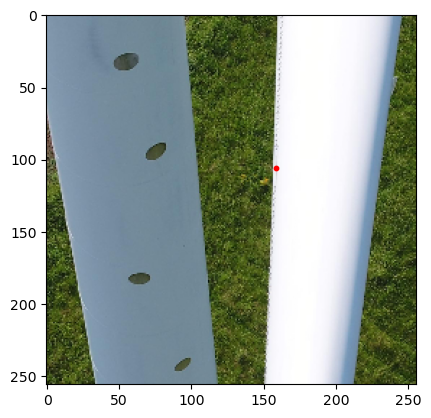

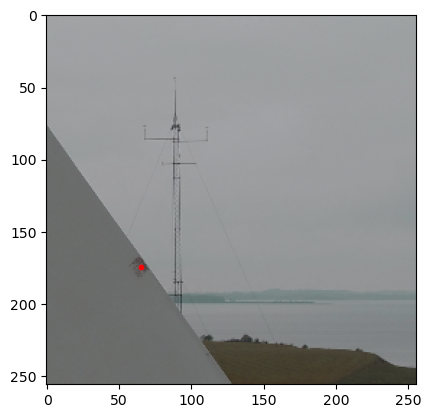

In [44]:
sub_image_test_original = OriginalDataset[1][10]
PlotCenterPoint(sub_image_test_original[0], sub_image_test_original[3])

sub_image_test_augmented = AugmentedDataset[1][10]
PlotCenterPoint(sub_image_test_augmented[0], sub_image_test_augmented[3])

## 5. **Convolutional Neural Network**

The approach presented in this study is presented below, covering both the architecture of the neural network and the description of the data set used for the training and evaluation processes.

**Training Dataset Description** 

The dataset consists of inspection images of wind turbines captured by drones. This dataset is processed and divided into distinct sets for training, validation and testing.

- **Training Set Processing**: The training set is generated by the **process_train_dataset function**, **combining original and augmented data**. Original data includes images, labels, bounding boxes and center points. Augmented data is obtained by applying transformations, such as horizontal and vertical flips, to enrich the diversity of the set;
- **Data Augmentation**: **Data augmentation techniques are applied during the processing of the training set**, using transformations such as horizontal and vertical flips. This practice aims to increase the variability of the set, enhancing the model's ability to generalize to different conditions;
- **Training Process**: The network is trained using the processed training set. The adopted loss function is the Cross-Entropy Loss, and optimization is performed using the Adam optimizer. The learning rate is set to 0.001, and an L2 regularization term with a value of 0.0001 is applied. Training occurs over multiple epochs, monitoring the network's performance on the validation set. Metrics such as accuracy and loss are recorded to evaluate the model's performance. The test set is reserved for final evaluations of the trained network's performance.


**Validation and Test Dataset Description**:

- **Validation and Test Datasets Description**: The validation and test datasets are meticulously processed using the **process_val_test_dataset function**, focusing on creating **original datasets without the application of data augmentation techniques**. The validation and test datasets play a crucial role in assessing the model's ability to generalize and perform accurately on new, unseen data. By relying on original data without augmentation, these datasets provide a realistic benchmark for evaluating the model's real-world applicability and performance across a spectrum of wind turbine inspection scenarios;
- **Processing Methodology**: The process_val_test_dataset function systematically combines original data for validation and test sets. Each dataset is organized by category, ensuring a comprehensive representation of diverse scenarios encountered during inspections.


**Neural Network Architecture**


**First CNN (SimpleConvNet)** 

The adopted architecture comprises a Convolutional Neural Network (CNN) designed for the detection of defects in images of wind turbines. The ConvolutionalNeuralNetwork class is responsible for defining the various layers that constitute the CNN. This includes convolutional layers, max pooling layers, fully connected layers, and activation functions. The structure is designed to extract relevant features from images and learn complex patterns.

- **Convolutional Layers**: Five convolutional layers with up to 64 filters, with a kernel size of 3 and stride of 2;

- **Max Pooling Layers**: Max pooling operations, performed by layers like max_pool_2 and max_pool_10, are incorporated for dimensionality reduction and extraction of important features;

- **Flatten Layer**: The flatten layer is used to convert the output of the convolutional layers into a one-dimensional vector;

- **Fully Connected Layers**: Only one fully connected layers, which is the output layer, contributing to learn more complex patterns;

- **Activation Functions**: Functions like ReLU, Sigmoid, Tanh, Leaky ReLU, and PReLU are applied after specific layers to introduce non-linearities;

- **Dropout Layers**: Dropout layers (dropout_10, dropout_20, etc.) are inserted for regularization, attempting to prevent overfitting;

- **Batch Normalization Layers**: Batch normalization layers (batch_norm32768, batch_norm16384, etc.) are included to stabilize training and make it converge quicker.



**Second CNN (MediumConvNet)** 

Building on the principles of the SimpleConvNet, the MediumConvNet also serves the purpose of detecting defects in wind turbine images. Its structure, similar to the SimpleConvNet, incorporates convolutional layers, max pooling layers, fully connected layers, and activation functions. Notably, due to an expanded head, the MediumConvNet boasts a **higher parameter count, totaling around 240M**, enhancing its capacity for capturing intricate patterns.

- **Convolutional Layers**: Five convolutional layers with up to 512 filters, with a kernel size of 3 and stride of 2;

- **Max Pooling Layers**: Max pooling operations, performed by layers like max_pool_2 and max_pool_10, are incorporated for dimensionality reduction and extraction of important features;

- **Flatten Layer**: The flatten layer is used to convert the output of the convolutional layers into a one-dimensional vector;

- **Fully Connected Layers**: Three fully connected layers, including the output layer, contributing to learn more complex patterns;

- **Activation Functions**: Functions like ReLU, Sigmoid, Tanh, Leaky ReLU, and PReLU are applied after specific layers to introduce non-linearities;

- **Dropout Layers**: Dropout layers (dropout_10, dropout_20, etc.) are inserted for regularization, attempting to prevent overfitting;

- **Batch Normalization Layers**: Batch normalization layers (batch_norm32768, batch_norm16384, etc.) are included to stabilize training and make it converge quicker.




**Third CNN (LargeConvNet)** 

In alignment with its predecessors, the LargeConvNet is designed for defect detection in wind turbine images. Leveraging the ConvolutionalNeuralNetwork class, it defines layers like convolutional, max pooling, fully connected, and activation functions. A key distinction lies in the expansive head, resulting in a substantial **parameter count of approximately 577M**, further enhancing its capability to learn intricate patterns.

- **Convolutional Layers**: Ten convolutional layers with up to 160 filters, with a kernel size varying from 64 to 4 and stride of 1;

- **Max Pooling Layers**: Max pooling operations, performed by layers like max_pool_2 and max_pool_10, are incorporated for dimensionality reduction and extraction of important features;

- **Flatten Layer**: The flatten layer is used to convert the output of the convolutional layers into a one-dimensional vector;

- **Fully Connected Layers**: Three fully connected layers, including the output layer, contributing to learn more complex patterns;

- **Activation Functions**: Functions like ReLU, Sigmoid, Tanh, Leaky ReLU, and PReLU are applied after specific layers to introduce non-linearities;

- **Dropout Layers**: Dropout layers (dropout_10, dropout_20, etc.) are inserted for regularization, attempting to prevent overfitting;

- **Batch Normalization Layers**: Batch normalization layers (batch_norm32768, batch_norm16384, etc.) are included to stabilize training and make it converge quicker.





**Regarding the results**, our focus has been on implementing the classification component thus far. This approach allowed us to assess various architectures systematically, ensuring optimal results, all the while considering the computational resources available to both authors for running the developed models.
Now, delving into the outcomes for each CNN:


**SimpleConvNet**:

- A compact architecture with **minimal parameters**;
- Exhibits **poor predictive power**, with an accuracy of 31.50% and weighted precision of 75.50%;
- The **weighted recall and F1 score are also low** at 31.50% and 38.63%, respectively.

**MediumConvNet**:
- A medium-sized CNN showing **significant improvements**;
- Presents **promising results with an accuracy of 74.50%**, and weighted precision, recall, and F1 score of 79.28%, 74.50%, and 76.47%, respectively;
- Despite better training results, **issues such as uncertainty in category assignment and a significant test loss of nearly 2.0 indicate the presence of overfitting**.

**LargeConvNet**:
- A relatively large CNN with **noteworthy improvements over SimpleConvNet**;
- Demonstrates **superior results with an accuracy of 72.75%**, and weighted precision, recall, and F1 score of 73.95%, 72.75%, and 73.13%, respectively;
- **Similar to MediumConvNet, LargeConvNet exhibits uncertainty in category assignment**, and the extended training time (128 epochs, 20 hours) reveals challenges with the last batch of validation data. The high loss in this batch, where all images have non-negative labels, suggests potential data quality issues. Addressing this, along with the **apparent overfitting**, is crucial for further progress.

In summary, while each CNN iteration brings improvements, challenges such as overfitting and uncertainty in category assignment persist. Addressing these issues, especially in data quality and model generalization, will be pivotal for advancing to the regression component of the project.


### **5.1 DataLoader Setup**

**Purpose**: Set up DataLoader instances for the training, validation, and test datasets to handle batching and shuffling.

**Key Aspects**:
- **DataLoader** instances (TrainDatasetLoader, ValDatasetLoader, TestDatasetLoader) are created with batch size and shuffling settings.

In [61]:
# Use DataLoader to handle batching and shuffling
batch_size = 128

# DataLoader for the training dataset with batch size and shuffling
TrainDatasetLoader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)

# DataLoader for the validation dataset with batch size (no shuffling)
ValDatasetLoader = DataLoader(ValDataset, batch_size=batch_size, shuffle=False)

# DataLoader for the test dataset with batch size (no shuffling)
TestDatasetLoader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)

### **5.2 Convolutional Neural Network Definition**

**Purpose**: Define the Convolutional Neural Network (CNN) architecture applied for the 3 examples (Simple, Medium and Large).

**Key Aspects**:
- **Convolutional layers** with increasing output channels;
- **Max pooling layers** with varying kernel sizes;
- **Fully connected layers** with decreasing output sizes;
- **Activation functions** (ReLU, Sigmoid, Tanh, etc.);
- **Dropout layers** with varying dropout rates;
- **Batch normalization layers**.

In [62]:
# Create a class that defines a simple Convolutional Neural Network (CNN)
class SmallConvolutionalNeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv_3_10 = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=2, padding=0)
        self.conv_10_16 = torch.nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.conv_16_20 = torch.nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, stride=2, padding=0)
        self.conv_20_32 = torch.nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv_32_64 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0)

        # Max pooling layers
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        self.max_pool_10 = torch.nn.MaxPool2d(kernel_size=10, stride=1)
        self.max_pool_15 = torch.nn.MaxPool2d(kernel_size=15, stride=1)
        self.max_pool_20 = torch.nn.MaxPool2d(kernel_size=20, stride=1)

        # Flatten layer
        self.flatten = torch.nn.Flatten()

        # Fully connected layers
        self.fc_255380_16384 = torch.nn.Linear(255380, 16384)
        self.fc_12168_4096 = torch.nn.Linear(12168, 4096)
        self.fc_4096_512 = torch.nn.Linear(4096, 512)
        self.fc_512_128 = torch.nn.Linear(512, 128)
        self.fc_25088_8192 = torch.nn.Linear(25088, 8192)
        self.fc_8192_4096 = torch.nn.Linear(8192, 4096)
        self.fc_6400_1024 = torch.nn.Linear(6400, 1024)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(3136, 6)

        # Activation functions
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu6 = torch.nn.ReLU6()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.prelu = torch.nn.PReLU()

        # Dropout layers
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)

        # Batch normalization layers
        self.batch_norm32768 = torch.nn.BatchNorm1d(32768)
        self.batch_norm16384 = torch.nn.BatchNorm1d(16384)
        self.batch_norm8192 = torch.nn.BatchNorm1d(8192)
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)


    # Forward pass through the network architecture
    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv_3_10(x))
        x = self.relu(self.conv_10_16(x))
        x = self.relu(self.conv_16_20(x))
        x = self.relu(self.conv_20_32(x))
        x = self.relu(self.conv_32_64(x))

        # Flatten layer
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.dropout_30(x)
        x = self.output_layer(x)

        return x
    
class MediumConvolutionalNeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv_3_32 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv_32_64 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0)
        self.conv_64_128 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0)
        self.conv_128_256 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=0)
        self.conv_256_512 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=0)

        # Max pooling layers
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        self.max_pool_10 = torch.nn.MaxPool2d(kernel_size=10, stride=1)
        self.max_pool_15 = torch.nn.MaxPool2d(kernel_size=15, stride=1)
        self.max_pool_20 = torch.nn.MaxPool2d(kernel_size=20, stride=1)

        # Flatten layer
        self.flatten = torch.nn.Flatten()

        # Fully connected layers
        self.fc_255380_16384 = torch.nn.Linear(255380, 16384)
        self.fc_12168_4096 = torch.nn.Linear(12168, 4096)
        self.fc_4096_512 = torch.nn.Linear(4096, 512)
        self.fc_512_128 = torch.nn.Linear(512, 128)
        self.fc_25088_8192 = torch.nn.Linear(25088, 8192)
        self.fc_8192_4096 = torch.nn.Linear(8192, 4096)
        self.fc_6400_1024 = torch.nn.Linear(6400, 1024)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(4096, 6)

        # Activation functions
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu6 = torch.nn.ReLU6()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.prelu = torch.nn.PReLU()

        # Dropout layers
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)

        # Batch normalization layers
        self.batch_norm32768 = torch.nn.BatchNorm1d(32768)
        self.batch_norm16384 = torch.nn.BatchNorm1d(16384)
        self.batch_norm8192 = torch.nn.BatchNorm1d(8192)
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)


    # Forward pass through the network architecture
    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv_3_32(x))
        x = self.relu(self.conv_32_64(x))
        x = self.relu(self.conv_64_128(x))
        x = self.relu(self.conv_128_256(x))
        x = self.relu(self.conv_256_512(x))

        # Flatten layer
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.dropout_30(x)
        x = self.relu(self.batch_norm8192(self.fc_25088_8192(x)))
        x = self.dropout_30(x)
        x = self.relu(self.batch_norm4096(self.fc_8192_4096(x)))
        x = self.output_layer(x)

        return x
    
# Create a class that creates a simple CNN
class LargeConvolutionalNeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_3_8 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 64, stride = 1, padding = 0)
        self.conv_8_10 = torch.nn.Conv2d(in_channels = 8, out_channels = 10, kernel_size = 64, stride = 1, padding = 0)
        self.conv_10_16 = torch.nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = 32, stride = 1, padding = 0)
        self.conv_16_20 = torch.nn.Conv2d(in_channels = 16, out_channels = 20, kernel_size = 32, stride = 1, padding = 0)
        self.conv_20_32 = torch.nn.Conv2d(in_channels = 20, out_channels = 32, kernel_size = 16, stride = 1, padding = 0)
        self.conv_32_40 = torch.nn.Conv2d(in_channels = 32, out_channels = 40, kernel_size = 16, stride = 1, padding = 0)
        self.conv_40_64 = torch.nn.Conv2d(in_channels = 40, out_channels = 64, kernel_size = 8, stride = 1, padding = 0)
        self.conv_64_80 = torch.nn.Conv2d(in_channels = 64, out_channels = 80, kernel_size = 8, stride = 1, padding = 0)
        self.conv_80_128 = torch.nn.Conv2d(in_channels = 80, out_channels = 128, kernel_size = 4, stride = 1, padding = 0)
        self.conv_128_160 = torch.nn.Conv2d(in_channels = 128, out_channels = 160, kernel_size = 4, stride = 1, padding = 0)
        # Max pooling layers
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size = 2, stride = 1)
        self.max_pool_10 = torch.nn.MaxPool2d(kernel_size = 10, stride = 1)
        self.max_pool_15 = torch.nn.MaxPool2d(kernel_size = 15, stride = 1)
        self.max_pool_20 = torch.nn.MaxPool2d(kernel_size = 20, stride = 1)
        # Flatten layer
        self.flatten = torch.nn.Flatten()
        # Fully connected layers
        self.fc_27040_16384 = torch.nn.Linear(27040, 16384)
        self.fc_16384_8192 = torch.nn.Linear(16384, 8192)
        self.fc_51840_16384 = torch.nn.Linear(51840, 16384)
        self.fc_12168_4096 = torch.nn.Linear(12168, 4096)
        self.fc_4096_512 = torch.nn.Linear(4096, 512)
        self.fc_512_128 = torch.nn.Linear(512, 128)
        self.fc_25088_8192 = torch.nn.Linear(25088, 8192)
        self.fc_8192_4096 = torch.nn.Linear(8192, 4096)
        self.fc_6400_1024 = torch.nn.Linear(6400, 1024)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(8192, 6)
        # Activation functions
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.relu6 = torch.nn.ReLU6()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.prelu = torch.nn.PReLU()
        # Dropout layers
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)
        # Batch normalization layers
        self.batch_norm32768 = torch.nn.BatchNorm1d(32768)
        self.batch_norm16384 = torch.nn.BatchNorm1d(16384)
        self.batch_norm8192 = torch.nn.BatchNorm1d(8192)
        self.batch_norm4096 = torch.nn.BatchNorm1d(4096)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)

    def forward(self, x):
        # Convolutional layers
        x = self.relu(self.conv_3_8(x))
        x = self.max_pool_2(self.relu(self.conv_8_10(x)))
        x = self.relu(self.conv_10_16(x))
        x = self.max_pool_2(self.relu(self.conv_16_20(x)))
        x = self.relu(self.conv_20_32(x))
        x = self.max_pool_2(self.relu(self.conv_32_40(x)))
        x = self.relu(self.conv_40_64(x))
        x = self.max_pool_2(self.relu(self.conv_64_80(x)))
        x = self.relu(self.conv_80_128(x))
        x = self.max_pool_2(self.relu(self.conv_128_160(x)))
        # Flatten layer
        x = self.flatten(x)
        # Fully connected layers
        x = self.dropout_20(x)
        x = self.relu(self.batch_norm16384(self.fc_27040_16384(x)))
        x = self.dropout_20(x)
        x = self.relu(self.batch_norm8192(self.fc_16384_8192(x)))
        x = self.output_layer(x)

        return x

### **5.3 Training Function**

**Purpose**: Train a neural network model using the provided training data, optimizer, and loss function.

**Key Aspects**:
- Training loop with specified epochs;
- Training and validation phases for each epoch;
- Monitoring training loss, accuracy, and validation loss, accuracy;
- TQDM used for progress visualization;
- Training results are stored in history lists.

In [26]:
def train_old(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = [], [], [], []

    # Create a plot with labeled axes
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target, bbox, centerpoint) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(ValDatasetLoader), total=len(ValDatasetLoader))

        for batch_idx, (data, target, bbox, centerpoint) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(
                f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} '
            )

        val_loss /= len(ValDatasetLoader)
        val_accuracy = 100 * correct / total
        print(f'Validation Cross-Entropy Loss = {val_loss:.4f}')
        print(f'Validation Accuracy = {val_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_accuracy)


    # Plot the training loss over epochs
    plt.plot(train_loss_hist, label='Training Loss')
    plt.plot(val_loss_hist, label='Validation Loss')
    plt.legend()
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [119]:
def train(model, train_loader, optimizer, loss_func, epochs, device, task_type='classification', **kwargs):
    """
    Trains a neural network model for either classification or regression.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - task_type (str): The type of task ('classification' or 'regression').
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch (classification only).
    - val_loss_hist (list): List containing validation loss values for each epoch.
    - val_acc_hist (list): List containing validation accuracy values for each epoch (classification only).
    """ 

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target, bbox, centerpoint) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            if task_type == 'classification':
                target = target.to(device)
            elif task_type == 'regression':
                bbox_tensor = torch.stack(bbox).transpose(0, 1).to(device, dtype=torch.float32)
                centerpoint_tensor = torch.stack(centerpoint).transpose(0, 1).to(device, dtype=torch.float32)
                target = centerpoint_tensor  # Or centerpoint

            model.zero_grad()
            output = model(data)

            if task_type == 'regression':
                # Usar apenas as primeiras 4 saídas do modelo para calcular a perda
                #output = output[:, :4]
                output = output[:, :2]

            if task_type == 'classification':
                loss = loss_fn(output, target)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            elif task_type == 'regression':
                # Ensure that the output and target have the same shape for regression loss
                loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % 10 == 0:  # A cada 10 lotes, imprima os valores para checagem
                print(f"Batch {batch_idx}")
                print(f"Predictions (output): {output[:5].detach().cpu().numpy()}")  # Imprime os primeiros 5 valores previstos
                print(f"Real (target): {target[:5].detach().cpu().numpy()}")  # Imprime os primeiros 5 valores reais

            if task_type == 'classification':
                pbar.set_description(
                    f'Training Cross-Entropy Loss = {loss.item():.4f} | Training Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1}'
                )
            elif task_type == 'regression':
                pbar.set_description(
                    f'Training Mean Squared Error Loss = {loss.item():.4f} | Batch ID = {batch_idx + 1}'
                )

        train_loss /= len(train_loader)
        train_loss_hist.append(train_loss)

        if task_type == 'classification':
            train_accuracy = 100 * correct / total
            train_acc_hist.append(train_accuracy)
            print(f'Training Loss = {train_loss:.4f} | Training Accuracy = {train_accuracy:.2f}%')

        elif task_type == 'regression':
            print(f'Training Loss = {train_loss:.4f}')


        # Validation phase
        print('======== Validation phase ========')
        model.eval()
        val_loss = 0.
        val_correct = 0.
        val_total = 0.
        pbar = tqdm(enumerate(ValDatasetLoader), total=len(ValDatasetLoader))

        for batch_idx, (data, target, bbox, centerpoint) in pbar:
            data = data.permute(0, 3, 1, 2).to(device, dtype=torch.float32)
            if task_type == 'classification':
                target = target.to(device)
            elif task_type == 'regression':
                bbox_tensor = torch.stack(bbox).transpose(0, 1).to(device, dtype=torch.float32)
                centerpoint_tensor = torch.stack(centerpoint).transpose(0, 1).to(device, dtype=torch.float32)
                target = centerpoint_tensor  
            
            output = model(data)

            if task_type == 'regression':
               #output = output[:, :4]
               output = output[:, :2]

            loss = loss_fn(output, target)
            val_loss += loss.item()

            if task_type == 'classification':
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        val_loss /= len(ValDatasetLoader)
        val_loss_hist.append(val_loss)

        if task_type == 'classification':
            val_accuracy = 100 * val_correct / val_total
            val_acc_hist.append(val_accuracy)
            print(f'Validation Cross-Entropy Loss = {val_loss:.4f} | Validation Accuracy = {val_accuracy:.2f}%')
            print()

        elif task_type == 'regression':
            print(f'Validation Mean Squared Error Loss = {val_loss:.4f}')
            print()

    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss_hist, label='Training Loss')
    plt.plot(val_loss_hist, label='Validation Loss')
    plt.legend()
    plt.show()

    # Print final training loss and accuracy if it's a classification task
    if task_type == 'classification':
        print(f"Final Cross-Entropy Loss on Training: {train_loss_hist[-1]:.4f}")
        print(f"Final Accuracy on Training: {train_acc_hist[-1]:.2f}%")
    elif task_type == 'regression':
        # For regression, you may want to return different metrics such as MSE or MAE
        print(f"Final Mean Squared Error Loss on Training: {train_loss_hist[-1]:.4f}")

    if task_type == 'classification':
        return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist
    elif task_type == 'regression':
        return train_loss_hist, None, val_loss_hist, None

### **5.4 Device Setup**

**Purpose**: Determine and set the device for training (GPU if available, else CPU).

**Key Aspects**:
- Checks for GPU availability using CUDA or Metal Performance Shaders (MPS) for Apple Silicon MacBooks;
- Default fallback to CPU if neither GPU nor MPS is available.

In [98]:
def set_device():
    # Checks for the availability of GPU using CUDA
    if torch.cuda.is_available():
        device = torch.device('cuda')
    # Checks if Multi-Process Service (MPS) is available
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    # If no GPU or MPS is available, uses CPU
    else:
        device = torch.device('cpu')
    
    # Prints and returns the selected device
    print('Device:', device)
    return device

### **5.5 Model Initialization and Training**

**Purpose**:
- Initialize the CNN model, loss function, and optimizer;
- Train the model using the training function.

**Key Aspects**:
- **CNN model (ConvolutionalNeuralNetwork)** is initialized and moved to the specified device;
- **CrossEntropyLoss** is used as the loss function;
- **Adam optimizer** is used with a learning rate of 0.001 and weight decay for L2 regularization;
- The model is trained for **16 epochs**.

#### **5.5.1 First CNN (SimpleConvNet)**

Device: cpu
Epoch 1/2
======== Training phase ========


Training Cross-Entropy Loss = 1.7923 | Training Accuracy = 19.53% | Batch ID = 1:   1%|▏         | 1/72 [00:01<01:33,  1.32s/it]

Batch 0
Predictions (output): [[ 0.01310696 -0.01169272  0.01025322  0.00405847 -0.00201549  0.01593589]
 [ 0.02342926  0.00304025 -0.00503058  0.02467782  0.00708125  0.01370654]
 [ 0.01291721  0.00174036 -0.00681939  0.00903505 -0.00844519  0.02405383]
 [ 0.01766901  0.00312173 -0.0043447   0.02681752 -0.01758917  0.02134106]
 [-0.00134265 -0.0011209  -0.00902869  0.0323407   0.00701403  0.02272129]]
Real (target): [3 5 4 0 3]


Training Cross-Entropy Loss = 1.8029 | Training Accuracy = 17.76% | Batch ID = 11:  15%|█▌        | 11/72 [00:09<00:51,  1.18it/s]

Batch 10
Predictions (output): [[ 0.07557438  0.13509536  0.00946333 -0.08933879  0.04837583 -0.16322431]
 [ 0.06470206  0.09877487  0.02216148 -0.08674079  0.02157243 -0.11985981]
 [ 0.07306354  0.08847538  0.02643177 -0.05548396  0.03298971 -0.11511349]
 [ 0.07875657  0.14278898  0.02359373 -0.10771179  0.04472651 -0.15695012]
 [ 0.09777682  0.154782   -0.00053571 -0.12654024  0.0591399  -0.1723178 ]]
Real (target): [0 0 3 4 4]


Training Cross-Entropy Loss = 1.7755 | Training Accuracy = 19.08% | Batch ID = 21:  29%|██▉       | 21/72 [00:17<00:39,  1.28it/s]

Batch 20
Predictions (output): [[ 0.03077157 -0.05865341  0.0025827   0.00873585  0.00686085  0.01956331]
 [ 0.04686932 -0.11401901  0.01349211  0.03634855 -0.03307116 -0.01329731]
 [ 0.00894413  0.008698   -0.02956082 -0.11722064  0.07544548  0.0109487 ]
 [-0.02278391  0.04153299 -0.03575978 -0.1335065   0.09047271  0.00998965]
 [ 0.0567584  -0.13789879  0.04197057  0.06693253 -0.05438884 -0.01158093]]
Real (target): [0 3 4 1 5]


Training Cross-Entropy Loss = 1.7388 | Training Accuracy = 20.59% | Batch ID = 31:  43%|████▎     | 31/72 [00:25<00:33,  1.21it/s]

Batch 30
Predictions (output): [[ 0.04884373 -0.53249717  0.28783193  0.33050817 -0.41780362  0.04466045]
 [ 0.1550337  -0.65718853  0.19508937  0.38638976 -0.46444824  0.04658303]
 [-0.02663589  0.01743396  0.09613156 -0.29571065 -0.11588179 -0.04600983]
 [-0.05865951  0.28292948  0.03908214 -0.6188844   0.07041923 -0.14359336]
 [ 0.24316537 -1.0053037   0.34707883  0.7103656  -0.71565884  0.09167995]]
Real (target): [0 4 1 0 2]


Training Cross-Entropy Loss = 1.7736 | Training Accuracy = 21.28% | Batch ID = 41:  57%|█████▋    | 41/72 [00:33<00:25,  1.19it/s]

Batch 40
Predictions (output): [[-0.01760066 -0.28706044 -0.1336731   0.19026631 -0.05847428  0.07363764]
 [-0.03122129 -0.16393937 -0.09591708  0.07567435  0.00437233  0.00078708]
 [-0.03242452  0.12735276 -0.21365698 -0.18769592  0.08967748 -0.1235005 ]
 [ 0.00991581 -0.00829312 -0.27368048 -0.06812862  0.08851913 -0.06291912]
 [ 0.02258715  0.3029761  -0.38740313 -0.32266384  0.07195432 -0.28944376]]
Real (target): [4 4 1 5 1]


Training Cross-Entropy Loss = 1.7193 | Training Accuracy = 22.55% | Batch ID = 51:  71%|███████   | 51/72 [00:41<00:16,  1.26it/s]

Batch 50
Predictions (output): [[-3.4306556e-02 -1.2971699e-01 -1.6732611e-02  2.0838911e-02
   2.7854770e-02 -5.0496005e-02]
 [-4.7699483e-03  6.6017687e-02 -3.4667719e-02 -3.4222147e-01
  -1.1646640e-03 -9.3238659e-02]
 [-1.6084649e-03  8.7416731e-03 -6.3080922e-02 -1.3747583e-01
   5.4166429e-02 -5.9429482e-02]
 [ 7.1602964e-01 -1.4133741e+00 -6.3853168e-01  9.8987281e-01
  -8.0877280e-01  3.5012725e-01]
 [ 3.9205706e-01 -8.4907335e-01 -3.0166304e-01  6.1166233e-01
  -4.1177678e-01  2.3095831e-01]]
Real (target): [0 1 5 5 5]


Training Cross-Entropy Loss = 1.7479 | Training Accuracy = 24.26% | Batch ID = 61:  85%|████████▍ | 61/72 [00:49<00:08,  1.28it/s]

Batch 60
Predictions (output): [[-0.30921182 -0.28097263  0.0600251  -0.04630459 -0.27907637  0.11203052]
 [-0.30312338 -0.56207114  0.19161238  0.07122412 -0.14038086  0.02484359]
 [-0.06703725 -0.62985414 -0.08156464  0.4438774  -0.28471908 -0.03161578]
 [ 0.71004474 -1.4459515  -0.07246669  0.87909156 -0.95538855  0.18894792]
 [-0.17725912 -0.0709293  -0.06809375 -0.5225958  -0.4940094   0.24007876]]
Real (target): [3 4 3 3 0]


Training Cross-Entropy Loss = 1.6564 | Training Accuracy = 24.81% | Batch ID = 71:  99%|█████████▊| 71/72 [00:57<00:00,  1.33it/s]

Batch 70
Predictions (output): [[-0.26419428 -0.17610274  0.02665416 -0.3842249   0.21045691 -0.19074203]
 [-0.21792133 -0.85962486 -0.22793423  0.5570465   0.30864403 -0.79680014]
 [-0.31585953 -0.5178073   0.17306463 -0.31130058  0.12548058 -0.43843442]
 [-0.26100063 -0.1773765   0.03537263 -0.5773445   0.30243954 -0.23705469]
 [-0.20269918 -0.10726148  0.09152447 -0.44933063  0.05171118  0.07353687]]
Real (target): [4 0 2 1 4]


Training Cross-Entropy Loss = 1.6736 | Training Accuracy = 24.89% | Batch ID = 72: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]


Training Loss = 1.7440 | Training Accuracy = 24.89%
======== Validation phase ========


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


Validation Cross-Entropy Loss = 1.8328 | Validation Accuracy = 8.92%

Epoch 2/2
======== Training phase ========


Training Cross-Entropy Loss = 1.6729 | Training Accuracy = 26.56% | Batch ID = 1:   1%|▏         | 1/72 [00:00<00:59,  1.20it/s]

Batch 0
Predictions (output): [[-0.02493604 -0.33555487 -0.1137145  -0.52488375  0.27990952 -0.17084062]
 [-0.12542348 -0.02857526 -0.08677363 -0.6973297   0.24931245 -0.49155122]
 [ 0.654563    0.67010576 -0.6226427  -1.7166078  -0.22785057  0.06923551]
 [-0.25212976  0.3255418  -0.29077405 -2.1485143   0.26800588 -0.54215103]
 [ 0.16408102 -0.4402429   0.27519906 -0.756525   -0.16926758 -0.11425672]]
Real (target): [3 0 0 2 3]


Training Cross-Entropy Loss = 1.6112 | Training Accuracy = 33.66% | Batch ID = 11:  15%|█▌        | 11/72 [00:08<00:44,  1.37it/s]

Batch 10
Predictions (output): [[-0.84007967  0.05322739 -0.8044971  -0.28365096 -0.3816256  -0.14126742]
 [-0.32376722 -0.1376438   0.19326219 -0.51711214 -0.03535099  0.01403741]
 [-0.4431259   0.7431593  -0.9526819  -1.6056947  -0.58905447 -0.5001661 ]
 [-0.4392454   0.0885473  -0.09504873 -0.6177122   0.03926323  0.07819379]
 [ 0.49438715 -0.5121023   0.05812333  0.10840375 -0.87430066 -0.20648977]]
Real (target): [3 2 3 2 4]


Training Cross-Entropy Loss = 1.5635 | Training Accuracy = 35.94% | Batch ID = 21:  29%|██▉       | 21/72 [00:15<00:37,  1.35it/s]

Batch 20
Predictions (output): [[-1.2825274   0.01673404  0.19516419 -1.5023686  -0.26019606 -0.32170865]
 [ 0.21719673 -0.659875   -0.12369103  0.39040482 -0.6923783   0.03341612]
 [ 0.2468318  -1.1512326  -0.01895992  1.0491409  -1.5891317   0.2572717 ]
 [ 0.58199686 -0.95504236  0.14573507  0.6399113  -1.7413977  -0.32056502]
 [-0.31120995 -0.9172399   0.49091083  0.5280944  -1.0564665  -1.2325202 ]]
Real (target): [1 3 3 0 0]


Training Cross-Entropy Loss = 1.4648 | Training Accuracy = 37.65% | Batch ID = 31:  43%|████▎     | 31/72 [00:22<00:30,  1.34it/s]

Batch 30
Predictions (output): [[-1.2048123  -0.19344361  0.56687045 -0.46535906 -0.35015568  0.12819022]
 [-0.692221    1.2743291   0.93732685 -3.7360935   0.20897448 -0.42485863]
 [-1.1797056   0.7665376   0.7606722  -3.7265666  -0.12809984  0.45780563]
 [-0.37136516 -0.11418085  0.21511449 -0.17538004 -0.8325624   0.21025483]
 [-1.3301997  -0.08910307  0.6067528  -1.2297935   0.17947032 -0.28846312]]
Real (target): [4 1 2 3 4]


Training Cross-Entropy Loss = 1.4883 | Training Accuracy = 39.12% | Batch ID = 41:  57%|█████▋    | 41/72 [00:30<00:23,  1.34it/s]

Batch 40
Predictions (output): [[-0.5882662   0.15691604  0.26985058 -0.5074666   0.10086749 -0.02212301]
 [-0.25781137 -0.04312075  0.07188787 -0.34784466  0.13246343  0.16768475]
 [ 0.38605383 -1.4597186  -1.6475154   2.05211    -1.1919616  -0.11909801]
 [ 0.64283586 -0.48342285  0.04137282 -0.8981101  -0.38186923 -0.25068754]
 [-0.5462203  -0.27241406  0.5000136  -1.3239932  -0.19562323 -0.47268564]]
Real (target): [2 4 3 5 4]


Training Cross-Entropy Loss = 1.3384 | Training Accuracy = 40.89% | Batch ID = 51:  71%|███████   | 51/72 [00:37<00:15,  1.33it/s]

Batch 50
Predictions (output): [[-0.75404346 -0.02966973  0.15740697 -0.39517495  0.23806839  0.3176669 ]
 [-1.8536834   0.93206054  0.6960603  -5.133139    1.317986   -0.98951244]
 [-1.6008832   1.1409873  -0.07178842 -4.2054853   0.6135616  -0.5321601 ]
 [-0.5587418   0.5799691  -0.51576144 -4.085412    1.668684   -1.3039529 ]
 [-0.7689976  -0.19017428 -0.27803537 -0.41213313  0.5502358   0.2833978 ]]
Real (target): [5 2 2 4 4]


Training Cross-Entropy Loss = 1.3255 | Training Accuracy = 42.58% | Batch ID = 61:  85%|████████▍ | 61/72 [00:45<00:08,  1.29it/s]

Batch 60
Predictions (output): [[ 0.48191786  0.5414521  -0.7279601  -5.0093274   0.32162097 -0.6230562 ]
 [-0.6627557  -0.69074976 -0.94142395  0.6981768   0.06856748 -0.70583254]
 [-0.8287418   0.06866596  0.0759967  -0.7081529   0.35464576  0.18508807]
 [-1.475916    1.1040859   0.17277321 -3.6455688  -0.3398513   0.43218595]
 [-0.22817914  0.14062956 -0.58       -1.4055539  -0.1420136   0.0492231 ]]
Real (target): [4 3 5 1 5]


Training Cross-Entropy Loss = 1.4333 | Training Accuracy = 43.45% | Batch ID = 71:  99%|█████████▊| 71/72 [00:52<00:00,  1.36it/s]

Batch 70
Predictions (output): [[ 0.19224453 -0.555736   -1.7844367  -0.08956428 -1.1629019  -0.2724786 ]
 [-0.04122044  0.09216543 -0.04932119 -1.0404172   0.26410836  0.02993422]
 [ 1.4591717  -0.5609376  -4.3281865   2.0813599  -1.0860165  -1.8815975 ]
 [-0.42812258  0.01094102 -0.62946     0.51083964 -0.08973343 -0.3306563 ]
 [-0.5166981  -0.921261   -0.8639983   1.98938     0.12652186 -0.86662936]]
Real (target): [1 1 3 1 3]


Training Cross-Entropy Loss = 1.3300 | Training Accuracy = 43.54% | Batch ID = 72: 100%|██████████| 72/72 [00:53<00:00,  1.35it/s]


Training Loss = 1.4759 | Training Accuracy = 43.54%
======== Validation phase ========


100%|██████████| 3/3 [00:00<00:00, 11.26it/s]


Validation Cross-Entropy Loss = 1.7308 | Validation Accuracy = 18.92%



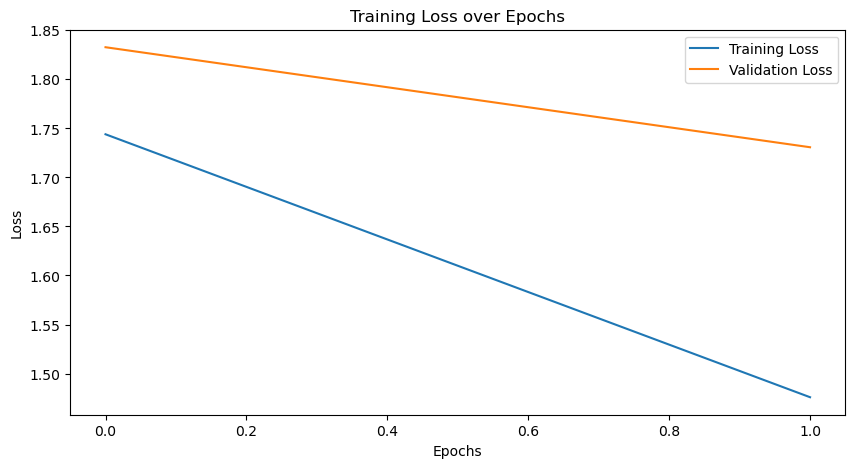

Final Cross-Entropy Loss on Training: 1.4759
Final Accuracy on Training: 43.54%


In [124]:
# Initialize the network, loss function, and optimizer
device = set_device()
SmallConvNet = SmallConvolutionalNeuralNet().to(device)
criterion_classification  = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SmallConvNet.parameters(), lr=0.001, weight_decay=0.0001)  # L2 regularization

# Train the model
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(SmallConvNet, TrainDatasetLoader, optimizer, criterion_classification , epochs = 2, device=device, task_type='classification')

Device: cpu
Epoch 1/2
======== Training phase ========


Training Mean Squared Error Loss = 18323.2480 | Batch ID = 1:   1%|▏         | 1/72 [00:01<01:22,  1.16s/it]

Batch 0
Predictions (output): [[-0.00076526  0.04362883]
 [ 0.00544025  0.03020929]
 [ 0.01579081  0.01173536]
 [ 0.00806036  0.03145037]
 [-0.00732464  0.01539116]]
Real (target): [[254.12506   59.24992 ]
 [ 15.999744 173.8752  ]
 [105.99962  213.2503  ]
 [196.75034  249.62483 ]
 [ 41.624577 188.37529 ]]


Training Mean Squared Error Loss = 18086.7715 | Batch ID = 11:  15%|█▌        | 11/72 [00:09<00:49,  1.23it/s]

Batch 10
Predictions (output): [[2.3158712 2.3942194]
 [2.1087887 2.1560905]
 [2.1412194 2.2485008]
 [2.1766307 2.166818 ]
 [2.3120852 2.3292782]]
Real (target): [[219.25018   70.49984 ]
 [  1.625088  88.3753  ]
 [252.50023   27.124992]
 [ 64.62515   22.375168]
 [ 93.87495  142.62503 ]]


Training Mean Squared Error Loss = 11422.9678 | Batch ID = 21:  29%|██▉       | 21/72 [00:17<00:38,  1.34it/s]

Batch 20
Predictions (output): [[37.409344 37.36372 ]
 [43.369915 43.941666]
 [35.58295  36.301025]
 [29.734037 30.175997]
 [29.724468 30.222826]]
Real (target): [[143.7499    10.49984 ]
 [  0.         0.      ]
 [ 62.374657  52.75008 ]
 [131.37459  254.24998 ]
 [  0.         0.      ]]


Training Mean Squared Error Loss = 7720.7871 | Batch ID = 31:  43%|████▎     | 31/72 [00:24<00:28,  1.43it/s] 

Batch 30
Predictions (output): [[98.78165  98.42759 ]
 [86.84894  86.30358 ]
 [93.71183  93.585686]
 [85.60657  83.18313 ]
 [82.57319  80.78268 ]]
Real (target): [[  0.         0.      ]
 [ 78.625534  77.37472 ]
 [ 84.749565 156.2501  ]
 [254.12506   59.24992 ]
 [254.12506   59.24992 ]]


Training Mean Squared Error Loss = 7680.3555 | Batch ID = 41:  57%|█████▋    | 41/72 [00:31<00:22,  1.41it/s]

Batch 40
Predictions (output): [[ 81.25532   83.742294]
 [101.44967  103.967545]
 [ 77.19143   80.871155]
 [ 75.11897   79.0794  ]
 [ 86.08349   89.16699 ]]
Real (target): [[  0.         0.      ]
 [230.12506   46.25024 ]
 [199.7499   100.12467 ]
 [225.37549   97.8752  ]
 [ 32.874752 116.12467 ]]


Training Mean Squared Error Loss = 6842.0298 | Batch ID = 51:  71%|███████   | 51/72 [00:38<00:14,  1.49it/s]

Batch 50
Predictions (output): [[ 92.34687   92.956314]
 [111.637794 113.55979 ]
 [ 91.98316   94.63761 ]
 [ 91.57752   93.53637 ]
 [117.71377  122.06109 ]]
Real (target): [[  1.874944  59.24992 ]
 [152.        67.6247  ]
 [231.99948  226.1248  ]
 [177.37447   77.37472 ]
 [129.62509  184.87502 ]]


Training Mean Squared Error Loss = 7365.8525 | Batch ID = 61:  85%|████████▍ | 61/72 [00:44<00:07,  1.51it/s]

Batch 60
Predictions (output): [[ 90.875206  90.610794]
 [111.57922  112.34436 ]
 [107.68624  107.52546 ]
 [106.82124  106.60424 ]
 [136.86792  137.28749 ]]
Real (target): [[129.49991  214.7497  ]
 [152.87552  201.2503  ]
 [  0.         0.      ]
 [239.2494    47.625217]
 [199.8743   144.12468 ]]


Training Mean Squared Error Loss = 7232.5908 | Batch ID = 71:  99%|█████████▊| 71/72 [00:51<00:00,  1.48it/s]

Batch 70
Predictions (output): [[116.64316  115.892586]
 [100.08864  100.99618 ]
 [ 95.64096   95.85758 ]
 [102.395164 103.15473 ]
 [110.62518  112.65916 ]]
Real (target): [[100.87552   71.49978 ]
 [255.12474  238.75021 ]
 [ 80.12544   93.250046]
 [188.12544  152.24986 ]
 [107.87482   40.625153]]


Training Mean Squared Error Loss = 7978.4805 | Batch ID = 72: 100%|██████████| 72/72 [00:52<00:00,  1.38it/s]


Training Loss = 10466.1031
======== Validation phase ========


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


Validation Mean Squared Error Loss = 9756.4504

Epoch 2/2
======== Training phase ========


Training Mean Squared Error Loss = 6468.1797 | Batch ID = 1:   1%|▏         | 1/72 [00:00<00:45,  1.55it/s]

Batch 0
Predictions (output): [[ 95.09357   95.6335  ]
 [ 94.430214  96.0078  ]
 [ 92.771324  92.74408 ]
 [102.20994  104.08972 ]
 [106.17546  107.13716 ]]
Real (target): [[  0.         0.      ]
 [  1.874944 196.75008 ]
 [190.1248   171.62521 ]
 [170.7497   128.12492 ]
 [ 65.8752    84.37479 ]]


Training Mean Squared Error Loss = 7536.9663 | Batch ID = 11:  15%|█▌        | 11/72 [00:07<00:38,  1.58it/s]

Batch 10
Predictions (output): [[ 98.91713  103.663216]
 [119.11203  124.882164]
 [112.07573  117.23083 ]
 [105.940506 110.857834]
 [ 86.64649   90.748535]]
Real (target): [[196.75034  128.      ]
 [162.12506  113.37498 ]
 [ 75.99974   12.374784]
 [218.87514   28.749825]
 [129.49991   41.250305]]


Training Mean Squared Error Loss = 6600.4229 | Batch ID = 21:  29%|██▉       | 21/72 [00:13<00:33,  1.50it/s]

Batch 20
Predictions (output): [[106.924255 106.80509 ]
 [110.681305 109.71438 ]
 [ 97.34597   98.25542 ]
 [ 96.28293   97.59004 ]
 [105.007675 105.4867  ]]
Real (target): [[ 59.249664 128.      ]
 [243.12474  157.62535 ]
 [ 65.8752    84.37479 ]
 [  0.         0.      ]
 [168.62541    2.625024]]


Training Mean Squared Error Loss = 7050.0156 | Batch ID = 31:  43%|████▎     | 31/72 [00:20<00:27,  1.49it/s]

Batch 30
Predictions (output): [[102.70659   99.96842 ]
 [ 99.79712   98.68026 ]
 [106.38691  104.481606]
 [105.45079  106.287025]
 [ 97.90566   96.746605]]
Real (target): [[ 27.24992   16.99968 ]
 [ 24.000511  29.8752  ]
 [205.62509   89.8752  ]
 [ 56.125694 111.87533 ]
 [130.87564  181.12486 ]]


Training Mean Squared Error Loss = 8046.2441 | Batch ID = 41:  57%|█████▋    | 41/72 [00:27<00:19,  1.55it/s]

Batch 40
Predictions (output): [[110.98735  113.10123 ]
 [ 99.681114 103.35921 ]
 [ 94.64986   97.25139 ]
 [ 96.65336   99.91623 ]
 [113.4726   116.41308 ]]
Real (target): [[183.37459  211.87532 ]
 [192.       241.50015 ]
 [  0.         0.      ]
 [ 78.625534 178.62527 ]
 [ 11.999744  25.499905]]


Training Mean Squared Error Loss = 6546.5122 | Batch ID = 51:  71%|███████   | 51/72 [00:33<00:13,  1.56it/s]

Batch 50
Predictions (output): [[109.361176 107.50331 ]
 [112.50893  115.369064]
 [102.96411  103.03251 ]
 [112.87328  109.20968 ]
 [105.64667  107.59078 ]]
Real (target): [[  0.         0.      ]
 [ 48.875008  95.37485 ]
 [196.75034  128.      ]
 [250.87488   95.37485 ]
 [ 16.750591 208.37479 ]]


Training Mean Squared Error Loss = 7473.7510 | Batch ID = 61:  85%|████████▍ | 61/72 [00:39<00:06,  1.59it/s]

Batch 60
Predictions (output): [[104.509254 101.1037  ]
 [109.99815  104.79372 ]
 [102.636246 100.23304 ]
 [130.20972  128.45049 ]
 [116.179794 112.67587 ]]
Real (target): [[126.62528   63.624702]
 [  5.8752     4.250112]
 [ 34.124287  86.37491 ]
 [148.62541  239.25018 ]
 [176.99994  193.24979 ]]


Training Mean Squared Error Loss = 7108.5845 | Batch ID = 71:  99%|█████████▊| 71/72 [00:46<00:00,  1.49it/s]

Batch 70
Predictions (output): [[100.95069   97.61153 ]
 [ 84.17402   81.64244 ]
 [114.53224  112.45709 ]
 [ 90.60865   87.51547 ]
 [ 92.74451   89.709045]]
Real (target): [[ 33.25056   93.249794]
 [ 13.12512   15.625216]
 [100.87552  184.50023 ]
 [  0.         0.      ]
 [  0.         0.      ]]


Training Mean Squared Error Loss = 7270.1968 | Batch ID = 72: 100%|██████████| 72/72 [00:46<00:00,  1.54it/s]


Training Loss = 7172.4914
======== Validation phase ========


100%|██████████| 3/3 [00:00<00:00, 12.41it/s]


Validation Mean Squared Error Loss = 10578.5833



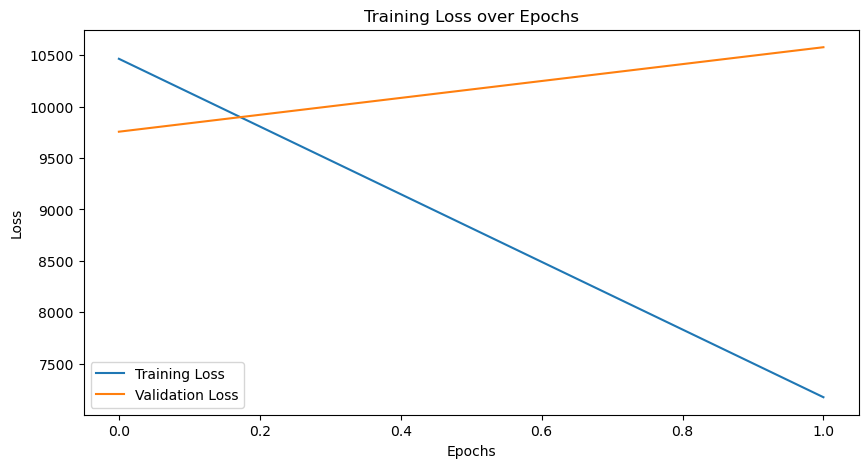

Final Mean Squared Error Loss on Training: 7172.4914


In [135]:
# Initialize the network, loss function, and optimizer
device = set_device()
SmallConvNet = SmallConvolutionalNeuralNet().to(device)
criterion_regression = torch.nn.MSELoss()  # Ou outra função de perda de regressão conforme necessário
optimizer = torch.optim.Adam(SmallConvNet.parameters(), lr=0.001, weight_decay=0.0001)  # Regularização L2

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(SmallConvNet, TrainDatasetLoader, optimizer, criterion_regression , epochs = 2, device=device, task_type='regression')

#### **5.5.2 Second CNN (MediumConvNet)**

In [136]:
# Initialize the network, loss function, and optimizer
device = set_device()
MediumConvNet = MediumConvolutionalNeuralNet().to(device)
criterion_classification = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MediumConvNet.parameters(), lr=0.001, weight_decay=0.0001)  # L2 regularization

# Train the model
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(MediumConvNet, TrainDatasetLoader, optimizer, criterion_classification, epochs = 8, device=device)

Device: cpu


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16736583680 bytes.

In [ ]:
# Initialize the network, loss function, and optimizer
device = set_device()
MediumConvNet = MediumConvolutionalNeuralNet().to(device)
criterion_regression = torch.nn.MSELoss()  # Ou outra função de perda de regressão conforme necessário
optimizer = torch.optim.Adam(MediumConvNet.parameters(), lr=0.001, weight_decay=0.0001)  # Regularização L2

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(MediumConvNet, TrainDatasetLoader, optimizer, criterion_regression , epochs = 2, device=device, task_type='regression')

#### **5.5.3 Third CNN (LargeConvNet)**

In [29]:
# Load a large CNN model
LargeConvNet = LargeConvolutionalNeuralNet().to(device)
LargeConvNet.load_state_dict(torch.load('models/CNN_577M_113.pth'))

<All keys matched successfully>

### **5.6 Testing**

**Purpose**: Evaluate the trained model on the test set.

**Key Aspects**:
- Testing function evaluates the model on the test set and computes various metrics:
- Test Cross-Entropy Loss;
- Test Weighted Accuracy;
- Test Weighted Precision;
- Test Weighted Recall;
- Test Weighted F1 Score;
- Results are printed using the tabulate library;
- Confusion matrix is displayed.

In [30]:
def test_old(model, test_loader, loss_func, device):

    model.eval()

    all_labels = []
    all_predictions = []
    test_loss = 0

    with torch.no_grad():
        for images, labels, bbox, centerpoint in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss_func(outputs, labels).item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)

    # Calculate weighted accuracy
    weighted_accuracy = accuracy_score(all_labels, all_predictions, normalize=True) * 100

    # Calculate weighted precision
    weighted_precision = precision_score(all_labels, all_predictions, average='weighted') * 100

    # Calculate weighted recall
    weighted_recall = recall_score(all_labels, all_predictions, average='weighted') * 100

    # Calculate weighted F1 score
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

    return test_loss, weighted_accuracy, weighted_precision, weighted_recall, weighted_f1, confusion_mat

In [130]:
def test(model, test_loader, loss_func, device, task_type='classification'):
    """
    Tests a neural network model for either classification or regression.

    Args:
    - model (torch.nn.Module): The neural network model to be tested.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
    - loss_func (torch.nn.Module): The loss function used for testing.
    - device (torch.device): The device on which the testing will be performed.
    - task_type (str): The type of task ('classification' or 'regression').

    Returns:
    - For classification: test_loss, weighted_accuracy, weighted_precision, weighted_recall, weighted_f1, confusion_mat
    - For regression: test_loss, mse, mae (and potentially other regression metrics)
    """

    model.eval()
    test_loss = 0

    all_labels = []
    all_predictions = []
    all_outputs = []

    with torch.no_grad():
        for images, labels, bbox, centerpoint in test_loader:
            images = images.to(device)
            images = images.permute(0, 3, 1, 2)
            outputs = model(images)

            if task_type == 'classification':
                labels = labels.to(device)
                _, predicted = torch.max(outputs.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
            elif task_type == 'regression':
                centerpoint_tensor = torch.stack(centerpoint).to(device, dtype=torch.float32).view(-1, 2)
                labels = centerpoint_tensor  # Agora labels é um tensor [batch_size, 2]
                outputs = outputs[:, :2]  # Saída do modelo agora é [batch_size, 2]
                all_outputs.extend(outputs.cpu().numpy()) 

            loss = loss_func(outputs, labels)
            test_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)

    if task_type == 'classification':
        # Convert lists to numpy arrays
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)

        # Calculate confusion matrix and other classification metrics
        confusion_mat = confusion_matrix(all_labels, all_predictions)
        weighted_accuracy = accuracy_score(all_labels, all_predictions) * 100
        weighted_precision = precision_score(all_labels, all_predictions, average='weighted') * 100
        weighted_recall = recall_score(all_labels, all_predictions, average='weighted') * 100
        weighted_f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

        return test_loss, weighted_accuracy, weighted_precision, weighted_recall, weighted_f1, confusion_mat

    elif task_type == 'regression':
        # For regression, calculate MSE, MAE, etc.
        mse = np.mean((np.array(all_labels) - np.array(all_outputs)) ** 2)
        mae = np.mean(np.abs(np.array(all_labels) - np.array(all_outputs)))

        # Here, return regression-specific metrics instead of classification metrics
        return test_loss, mse, mae

### **5.7 Showcasing results**

**Purpose**: Evaluate the trained model on the test set.

**Key Aspects**:
- Testing function evaluates the model on the test set and computes various metrics:
- **Test Cross-Entropy Loss**;
- **Test Weighted Accuracy**;
- **Test Weighted Precision**;
- **Test Weighted Recall**;
- **Test Weighted F1 Score**;
- **Results are printed using the tabulate library**;
- **Confusion matrix is displayed**.

In [31]:
def ShowResults_old(model, TestDatasetLoader, criterion, device):
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_precision, test_recall, test_f1_score, confusion_mat = test(model, TestDatasetLoader, criterion, device)

    # Count the number of parameters in the model
    # The number of trainable parameters must be wrong... Right???
    '''trainable_num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Create a table with the total number of parameters
    params_table = [
                    ["Trainable Parameters", f"{trainable_num_params:,}"]
                    ]'''

    # Display the results using tabulate
    results_table = [
        ["Test Cross-Entropy Loss", f"{test_loss:.4f}"],
        ["Test Weighted Accuracy", f"{test_accuracy:.2f}%"],
        ["Test Weighted Precision", f"{test_precision:.2f}%"],
        ["Test Weighted Recall", f"{test_recall:.2f}%"],
        ["Test Weighted F1 Score", f"{test_f1_score:.2f}%"],
    ]

    # Display the confusion matrix as a table and add row and column headers and center the values
    confusion_table = tabulate(confusion_mat, 
                            headers=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"], 
                            tablefmt="fancy_grid", 
                            showindex=["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5"],
                            stralign="center", 
                            numalign="center")

    # Print or save the results
    '''print(tabulate(params_table, headers=["Total number of trainable parameters", "Value"], tablefmt="fancy_grid", stralign="center", numalign="center"))
    print()'''
    print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid", stralign="center", numalign="center"))
    print()
    print("Confusion Matrix:")
    print(confusion_table)

In [131]:
def ShowResults(model, TestDatasetLoader, criterion, device, task_type='classification'):
    # Avalia o modelo no conjunto de teste
    if task_type == 'classification':
        test_loss, accuracy, precision, recall, f1_score, confusion_mat = test(
            model, TestDatasetLoader, criterion, device, task_type='classification'
        )

        # Exibe os resultados usando tabulate
        results_table = [
            ["Test Loss", f"{test_loss:.4f}"],
            ["Accuracy", f"{accuracy:.2f}%"],
            ["Precision", f"{precision:.2f}%"],
            ["Recall", f"{recall:.2f}%"],
            ["F1 Score", f"{f1_score:.2f}%"],
        ]

        # Exibe a matriz de confusão como uma tabela
        confusion_table = tabulate(
            confusion_mat,
            headers=["Predicted " + str(i) for i in range(len(confusion_mat))],
            showindex=["Actual " + str(i) for i in range(len(confusion_mat))],
            tablefmt="fancy_grid",
            stralign="center",
            numalign="center"
        )

        print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid", stralign="center", numalign="center"))
        print("\nConfusion Matrix:")
        print(confusion_table)

    elif task_type == 'regression':
        test_loss, mse, mae = test(
            model, TestDatasetLoader, criterion, device, task_type='regression'
        )

        # Exibe os resultados para regressão
        results_table = [
            ["Test Loss", f"{test_loss:.4f}"],
            ["MSE", f"{mse:.4f}"],
            ["MAE", f"{mae:.4f}"]
        ]

        print(tabulate(results_table, headers=["Metric", "Value"], tablefmt="fancy_grid", stralign="center", numalign="center"))

#### **5.7.1 Results for the Small CNN**

This very small CNN, which has very **few parameters**, presents a very **pour predictive power for the classification task in hand**. Although it presented a weighted precision of 75.50%, the fact is that for the rest of the metrics we got an **accuracy of 31.50%**, a **weighted recall of 31.50%** and because the harmonic mean computed by the weighted F1 score focuses on the worse result between weighted recall and weighted precision, we got a value of 38.63%.

In [132]:
ShowResults(SmallConvNet, TestDatasetLoader, criterion_classification, device, task_type='classification')

╒═══════════╤═════════╕
│  Metric   │  Value  │
╞═══════════╪═════════╡
│ Test Loss │ 1.6571  │
├───────────┼─────────┤
│ Accuracy  │ 19.50%  │
├───────────┼─────────┤
│ Precision │ 76.79%  │
├───────────┼─────────┤
│  Recall   │ 19.50%  │
├───────────┼─────────┤
│ F1 Score  │ 24.50%  │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│          │  Predicted 0  │  Predicted 1  │  Predicted 2  │  Predicted 3  │  Predicted 4  │  Predicted 5  │
╞══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Actual 0 │       4       │       2       │       0       │       7       │       3       │       1       │
├──────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ Actual 1 │       1       │      14       │       5       │       2       │       7       │       2       │
├──────────┼───

In [133]:
ShowResults(SmallConvNet, TestDatasetLoader, criterion_regression, device, task_type='regression')

╒═══════════╤═════════╕
│  Metric   │  Value  │
╞═══════════╪═════════╡
│ Test Loss │ 7244.72 │
├───────────┼─────────┤
│    MSE    │ 3793.3  │
├───────────┼─────────┤
│    MAE    │ 21.755  │
╘═══════════╧═════════╛


#### **5.7.2 Results for the Medium CNN**

This medium size CNN (relatively speaking), presents **way more promising results in terms of predictive power for the classification task in hand**. It presents an **accuracy of 74.50%**, and **weigted precision, recall and F1 score of 79.28%, 74.50% and 76.47%**, respectively. Looking at the confusion matrix and the test loss, we can also say that this MediumConvNet still shows **some uncertainty regarding to what category should it assign the test images**. This, compounded with the much better training results, show the obvious **presence of overfitting**. One thing that caught us off guard is that the test loss of nearly 2.0 doesn't seem to be suited for a model with these classification results. The very high validation/test loss is still one of the biggest challenges, and also one of the reasons why we still didn't go to the regression component of the project.


In [134]:
ShowResults(MediumConvNet, TestDatasetLoader, criterion, device, task_type='classification')

NameError: name 'MediumConvNet' is not defined

In [32]:
ShowResults(MediumConvNet, TestDatasetLoader, criterion_regression, device, task_type='regression')

╒═════════════════════════╤═════════╕
│         Metric          │  Value  │
╞═════════════════════════╪═════════╡
│ Test Cross-Entropy Loss │ 1.9590  │
├─────────────────────────┼─────────┤
│ Test Weighted Accuracy  │ 74.50%  │
├─────────────────────────┼─────────┤
│ Test Weighted Precision │ 79.28%  │
├─────────────────────────┼─────────┤
│  Test Weighted Recall   │ 74.50%  │
├─────────────────────────┼─────────┤
│ Test Weighted F1 Score  │ 76.47%  │
╘═════════════════════════╧═════════╛

Confusion Matrix:
╒══════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│          │  Predicted 0  │  Predicted 1  │  Predicted 2  │  Predicted 3  │  Predicted 4  │  Predicted 5  │
╞══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Actual 0 │       7       │       4       │       0       │       0       │       0       │       6       │
├──────────┼───────────────┼───────────────┼───────

#### **5.7.3 Results for the Large CNN**

This large size CNN (relatively speaking), also presents **way better results and predictive power for the classification task in hand when compared with the SmallConvNet**. It presents an accuracy of **72.75%**, and **weigted precision, recall and F1 score of 73.95%, 72.75%, and 73.13%**, respectively. Looking at the confusion matrix and the test loss, we can also say that this LargeConvNet still shows some uncertainty regarding to what category should it assign the test images. Because this CNN took a **lot more time to train (for 128 epochs, 20 hours)**, it was easier to see from where does the loss of 5.0176 come from; the loss in the first to batches of the validation set are okay, around 1.3 and 1.5, however the last batch of validation data always gets a way higher validation loss, meaning that the problem is in the images present in this last batch, which presents all images with non-negative labels. This might mean that something should be done to improve the data quality, for example not implementing a hue change in the data augmentation set (do we want to say to the model that grass can be purple and the sky red?). This, compounded with the much better training results, shows the obvious presence of overfitting.

In [33]:
ShowResults(LargeConvNet, TestDatasetLoader, criterion_regression, device, task_type='classification')

╒═════════════════════════╤═════════╕
│         Metric          │  Value  │
╞═════════════════════════╪═════════╡
│ Test Cross-Entropy Loss │ 5.0176  │
├─────────────────────────┼─────────┤
│ Test Weighted Accuracy  │ 72.75%  │
├─────────────────────────┼─────────┤
│ Test Weighted Precision │ 73.95%  │
├─────────────────────────┼─────────┤
│  Test Weighted Recall   │ 72.75%  │
├─────────────────────────┼─────────┤
│ Test Weighted F1 Score  │ 73.13%  │
╘═════════════════════════╧═════════╛

Confusion Matrix:
╒══════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│          │  Predicted 0  │  Predicted 1  │  Predicted 2  │  Predicted 3  │  Predicted 4  │  Predicted 5  │
╞══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Actual 0 │       6       │       1       │       0       │       1       │       0       │       9       │
├──────────┼───────────────┼───────────────┼───────

In [ ]:
ShowResults(LargeConvNet, TestDatasetLoader, criterion_regression, device, task_type='regression')

In [46]:
# Retrieve the data from all batches of the test dataset
all_val_labels = []
all_val_bboxes = []
all_val_centerpoints = []

with torch.no_grad():
    for images, labels, bboxes, centerpoints in ValDatasetLoader:
        images = images.to(device)
        labels = labels.to(device)
        images = images.permute(0, 3, 1, 2)

        all_val_labels.extend(labels.cpu().numpy())
        all_val_bboxes.extend(bboxes)
        all_val_centerpoints.extend(centerpoints)

# Convert lists to numpy arrays
all_test_labels = np.array(all_val_labels)
all_test_bboxes = np.array(all_val_bboxes)
all_test_centerpoints = np.array(all_val_centerpoints)

# Display the labels from the last batch of the validation dataset
print('Labels from the last batch of the validation dataset:')
print(all_test_labels[-batch_size:])

Labels from the last batch of the validation dataset:
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4]


To still developing....

In [ ]:
'''# Load the pre-trained weights of YOLO
yolo_model = YOLOModel()
yolo_model.load_weights('yolo_weights.pth')

# Run YOLO on the test dataset and obtain predictions
yolo_predictions = yolo_model.predict(test_dataset)

# Evaluate the performance of YOLO
yolo_metrics = evaluate(yolo_predictions, test_labels)

# Load the pre-trained weights of Faster R-CNN
faster_rcnn_model = FasterRCNNModel()
faster_rcnn_model.load_weights('faster_rcnn_weights.pth')

# Run Faster R-CNN on the test dataset and obtain predictions
faster_rcnn_predictions = faster_rcnn_model.predict(test_dataset)

# Evaluate the performance of Faster R-CNN
faster_rcnn_metrics = evaluate(faster_rcnn_predictions, test_labels)

# Evaluate the performance of your AI model
ai_model_metrics = evaluate(ai_model_predictions, test_labels)

# Compare the results
print("YOLO Metrics:", yolo_metrics)
print("Faster R-CNN Metrics:", faster_rcnn_metrics)
print("AI Model Metrics:", ai_model_metrics)'''


In [31]:
'''#Para considerar se quisermos aplicar o Tensorboard
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()


for epoch in range(epochs):
    for batch in TrainDatasetLoader:
            #adicionar treino aqui

    val_loss, val_accuracy = evaluate(model, ValDatasetLoader, criterion, device)
    

    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)


writer.close()
'''

"#Para considerar se quisermos aplicar o Tensorboard\nfrom torch.utils.tensorboard import SummaryWriter\n\n\nwriter = SummaryWriter()\n\n\nfor epoch in range(epochs):\n    for batch in TrainDatasetLoader:\n            #adicionar treino aqui\n\n    val_loss, val_accuracy = evaluate(model, ValDatasetLoader, criterion, device)\n    \n\n    writer.add_scalar('Loss/Train', train_loss, epoch)\n    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)\n    writer.add_scalar('Loss/Validation', val_loss, epoch)\n    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)\n\n\nwriter.close()\n"